## Installing some libraries

In [ ]:
!apt-get install net-tools tcpdump iputils-ping dnsutils tshark curl
!pip install --pre scapy[basic]
!pip install pyshark
!pip install nest_asyncio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.68.0-1ubuntu2.18).
The following additional packages will be installed:
  bind9-dnsutils bind9-host bind9-libs libc-ares2 liblua5.2-0 libmaxminddb0
  libnl-genl-3-200 libpcap0.8 libsbc1 libsmi2ldbl libspandsp2 libspeexdsp1
  libwireshark-data libwireshark13 libwiretap10 libwsutil11 wireshark-common
Suggested packages:
  mmdb-bin snmp-mibs-downloader geoipupdate geoip-database
  geoip-database-extra libjs-leaflet libjs-leaflet.markercluster wireshark-doc
  apparmor
The following NEW packages will be installed:
  bind9-dnsutils bind9-host bind9-libs dnsutils iputils-ping libc-ares2
  liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpcap0.8 libsbc1 libsmi2ldbl
  libspandsp2 libspeexdsp1 libwireshark-data libwireshark13 libwiretap10
  libwsutil11 net-tools tcpdump tshark wireshark-common
0 upgraded, 22 newly installed, 0 to remove and 23 not upgraded.
Need to g

### Mounting the drive with the data on it (both initial and a few weeks later datasets)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Collecting the data

It is time to collect the data. To do so, the following bash skript visits each website in the 'websites' lists 10 times. Tcpdump starts listening immidiately, when after the fifth second the website is visited. Then each visit is saved in a pcap file (indexed from 1 to 10) in a folder corresponding to a website, therefore we finally will have 10 folders with 10 pcap files in each one of them. We filter out the unnecessary data, since we know that https corresponds to port 443 and that the host is the website, so we can capture all traffic to and from the given host. This method is quite slow, and the example of tshark from 'Wifi sniffing' lecture could be used, but since the scriptbefore the lecture was covered, I decided to keep my implementation.


In [ ]:
!bash get_data.sh

Load the laibraries to be used later

In [ ]:
import os
import pyshark
import nest_asyncio
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

The following funcrion talkes as input a tuple (both IPs and both ports) and a corresponding to the tuple flow. It outputs a dictionary with the features, like ips, ports, number of packets, statistical features on the number of bytes and inter arrival time.

In [ ]:
# input - tuple, dataframe --> statistical features 
def extract_features(flow, df_flow):
    flow_features = {}

    flow_features['s_ip'] = flow[0]
    flow_features['s_port'] = flow[2]

    flow_features['d_ip'] = flow[1]
    flow_features['d_port'] = flow[3]

    flow_features['num_packets'] = len(df_flow)
    
    pkt_sizes = df_flow['packet.length'].astype(float)

    flow_features['total_bytes'] = pkt_sizes.sum()
    flow_features['mean_pac_size'] = pkt_sizes.mean()
    flow_features['min_pac_size'] = pkt_sizes.min()
    flow_features['max_pac_size'] = pkt_sizes.max()
    flow_features['std_pac_size'] = pkt_sizes.std()


    iat = 100*df_flow['packet.sniff_timestamp'].astype(float).diff(1).iloc[1:]#ignore the first element

    flow_features['mean_iat'] = iat.mean()
    flow_features['min_iat'] = iat.min()
    flow_features['max_iat'] = iat.max()
    flow_features['std_iat'] = iat.std()
    #flow_features['dur'] = iat.sum() # not required

    return flow_features

In the following cell we parse for a given capture extract a packet and convert it into a row of a pandas dataframe. Then, since we consider bidirectional flows, we swap source and destination, so that it is easier to apply a group by operation. Than for each groupped flow we extract the features using the function described above. After that we incert the features in the final dataframe with a label corresponding to a website we consider. The following procedure is repeated for every file/capture and for every folder/website.

In [ ]:
def dataset_generator(directory):
    result_df = pd.DataFrame()

    folders = [f for f in os.listdir(directory) if f.startswith('www.')] # avoid default folders

    # for every folder
    for folder_ in folders:
        folder_path = os.path.join(directory, folder_)

        # label is, basically, www.(label).com
        label = folder_.split('.')[1]

        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))] # make sure it is a file

        # for every file in a folder
        for file_ in files:
          file_path = os.path.join(folder_path, file_)
          
          #create a df
          df = pd.DataFrame()
          
          nest_asyncio.apply()
          cap = pyshark.FileCapture(file_path)
          
          # start parcing every packet in a capture
          for packet in cap:
              #prepare a row
              new_row = {'packet.ip.src':packet.ip.src, 
                          'packet.tcp.srcport':packet.tcp.srcport, 
                          'packet.ip.dst':packet.ip.dst, 
                          'packet.tcp.dstport':packet.tcp.dstport,
                          'packet.length':packet.length,
                          'packet.sniff_timestamp':packet.sniff_timestamp} 
              # append the row          
              df = df.append(new_row, ignore_index = True)
          # close the capture
          cap.close()
          
          for index, row in df.iterrows(): # FOR FURTHER AGGREAGATION OF UPLINK AND DOUNLINK
              if row['packet.ip.src'] !='172.28.0.12':# not VM's address -> downlinlk
                
                  temp = row['packet.ip.src']
                  row['packet.ip.src'] = row['packet.ip.dst']
                  row['packet.ip.dst'] = temp 

                  temp = row['packet.tcp.srcport']
                  row['packet.tcp.srcport'] = row['packet.tcp.dstport']
                  row['packet.tcp.dstport'] = temp 

          try:
            df_grouped = df.groupby(['packet.ip.src','packet.ip.dst','packet.tcp.srcport','packet.tcp.dstport']) # group by socket
          except KeyError: # empty capture
            continue;

          for flow, df_flow in df_grouped: # get the socket and a flow
              features_per_flow = extract_features(flow, df_flow)# extract the needed features
              features_per_flow['label'] = label # insert the label
          
              result_df = result_df.append(features_per_flow, ignore_index = True) # insert a row into a final dataset
    return result_df

This is the initial data. Later on it will be refered to as 'old data'. We apply the function on the captures to create an aggregated csv file with all the data and store it in the first dataframe.

In [ ]:
data_old = '/content/drive/MyDrive/Colab Notebooks/Network measurements/data_hw2'
result_df1 = dataset_generator(data_old)
display(result_df1)

s_ip s_port            d_ip d_port  num_packets  total_bytes  \
0   172.28.0.12  51082    104.86.74.16    443          543    1979575.0   
1   172.28.0.12  49292    104.86.74.16    443          514    1977856.0   
2   172.28.0.12  47488    104.86.74.16    443          348    1978823.0   
3   172.28.0.12  54290  104.79.131.248    443          233    1971274.0   
4   172.28.0.12  33122  104.79.131.248    443          231    1971113.0   
..          ...    ...             ...    ...          ...          ...   
93  172.28.0.12  40786    69.192.39.25    443           38      10099.0   
94  172.28.0.12  54956    69.192.39.25    443           41      10284.0   
95  172.28.0.12  56122    69.192.39.25    443           41      10284.0   
96  172.28.0.12  45034    69.192.39.25    443           36       9967.0   
97  172.28.0.12  60116    69.192.39.25    443           41      10284.0   

    mean_pac_size  min_pac_size  max_pac_size  std_pac_size  mean_iat  \
0     3645.626151          54.0       56538.0   7791.485715  1.522852   
1     3847.968872          54.0       56538.0   7990.024742  1.784577   
2     5686.272989          54.0       56538.0  12439.426030  2.985266   
3     8460.403433          54.0       56538.0  15442.859075  3.502391   
4     8532.956710          54.0       56538.0  15910.874006  3.524936   
..            ...           ...           ...           ...       ...   
93     265.763158          54.0        2962.0    547.437492  0.164392   
94     250.829268          54.0        2962.0    529.238788  0.149993   
95     250.829268          54.0        2962.0    529.238788  0.206957   
96     276.861111          54.0        2962.0    561.311228  0.171245   
97     250.829268          54.0        2962.0    529.238788  0.150780   

     min_iat     max_iat    std_iat           label  
0  -0.002313  804.336095  34.548038  washingtonpost  
1  -0.002313  900.932789  39.776062  washingtonpost  
2  -0.003409  998.509216  53.597687  washingtonpost  
3  -0.005412  798.312402  52.408369  washingtonpost  
4  -0.002885  800.128698  52.756028  washingtonpost  
..       ...         ...        ...             ...  
93 -0.001597    0.997996   0.288292      indiatimes  
94 -0.000691    0.804615   0.255221      indiatimes  
95 -0.001597    2.092600   0.432168      indiatimes  
96 -0.000596    0.794697   0.285035      indiatimes  
97 -0.000787    1.102281   0.289352      indiatimes  

[98 rows x 15 columns]

The following functions implement a procedure which f1) normalizes the data, splits it and f2) implements KNN classiier (manually), outputs the accuracy and the confusion matrix for each 'K'.

In [ ]:
def Stand_Scaler_split(X,Y):
    idx = np.random.permutation(len(X))
    num_train_obs = np.floor(0.7*len(X)) # 70/30 split

    # ind of the train and test samples
    train_idx = idx[1:int(num_train_obs)]
    test_idx = idx[int(num_train_obs):]

    X_norm = pd.DataFrame() # standard scaler
    for key in X:
        temp = X[key]
        temp_norm = (temp-temp.mean())/temp.std();
        X_norm[key] = temp_norm

    # split train / test
    X_norm_train = X_norm.iloc[train_idx]
    X_norm_test = X_norm.iloc[test_idx]

    Y_train = Y.iloc[train_idx]
    Y_test = Y.iloc[test_idx]
    return X_norm_train, X_norm_test, Y_train, Y_test

def KNN(X_norm_train, X_norm_test, Y_train, Y_test): # knn classifier
    accuracy_k = []
    for k in range(1,10+1):# number of neig.
        i = 0;# sample to be tested 
        accuracy = 0
        Y_test_predicted = []
        for index, row in X_norm_test.iterrows(): # compute all the distances to the test sample
            distances = []
            for _ , rr in X_norm_train.iterrows():
                distances.append(np.linalg.norm(np.array(row.to_numpy() - rr.to_numpy())))
            
            if k == 1:# can't use mode here
              min_idx = np.argmin(distances)
              predicted_Y = Y_train.iloc[min_idx]
            else:
              sorted_idx = np.argsort(distances)
              predicted_Y = Y_train.iloc[sorted_idx[0:k]].mode()[0]
          
            Y_test_predicted.append(predicted_Y)
            if(Y_test.iloc[i] == predicted_Y):
              accuracy = accuracy+1
            i = i+1

        # accuracy in percents
        print('Accuracy for K=', k,':', accuracy/len(Y_test))
        accuracy_k.append(accuracy/len(Y_test))

        # confusion matrix for each 'K'
        fig, ax = plt.subplots(figsize=(4, 4))
        ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_predicted, ax=ax)
        ax.set_title('K=' + str(k))
    
    return accuracy_k

Accuracy for K= 1 : 0.9666666666666667
Accuracy for K= 2 : 0.8666666666666667
Accuracy for K= 3 : 0.8666666666666667
Accuracy for K= 4 : 0.7
Accuracy for K= 5 : 0.7333333333333333
Accuracy for K= 6 : 0.7
Accuracy for K= 7 : 0.6666666666666666
Accuracy for K= 8 : 0.5
Accuracy for K= 9 : 0.5
Accuracy for K= 10 : 0.4666666666666667


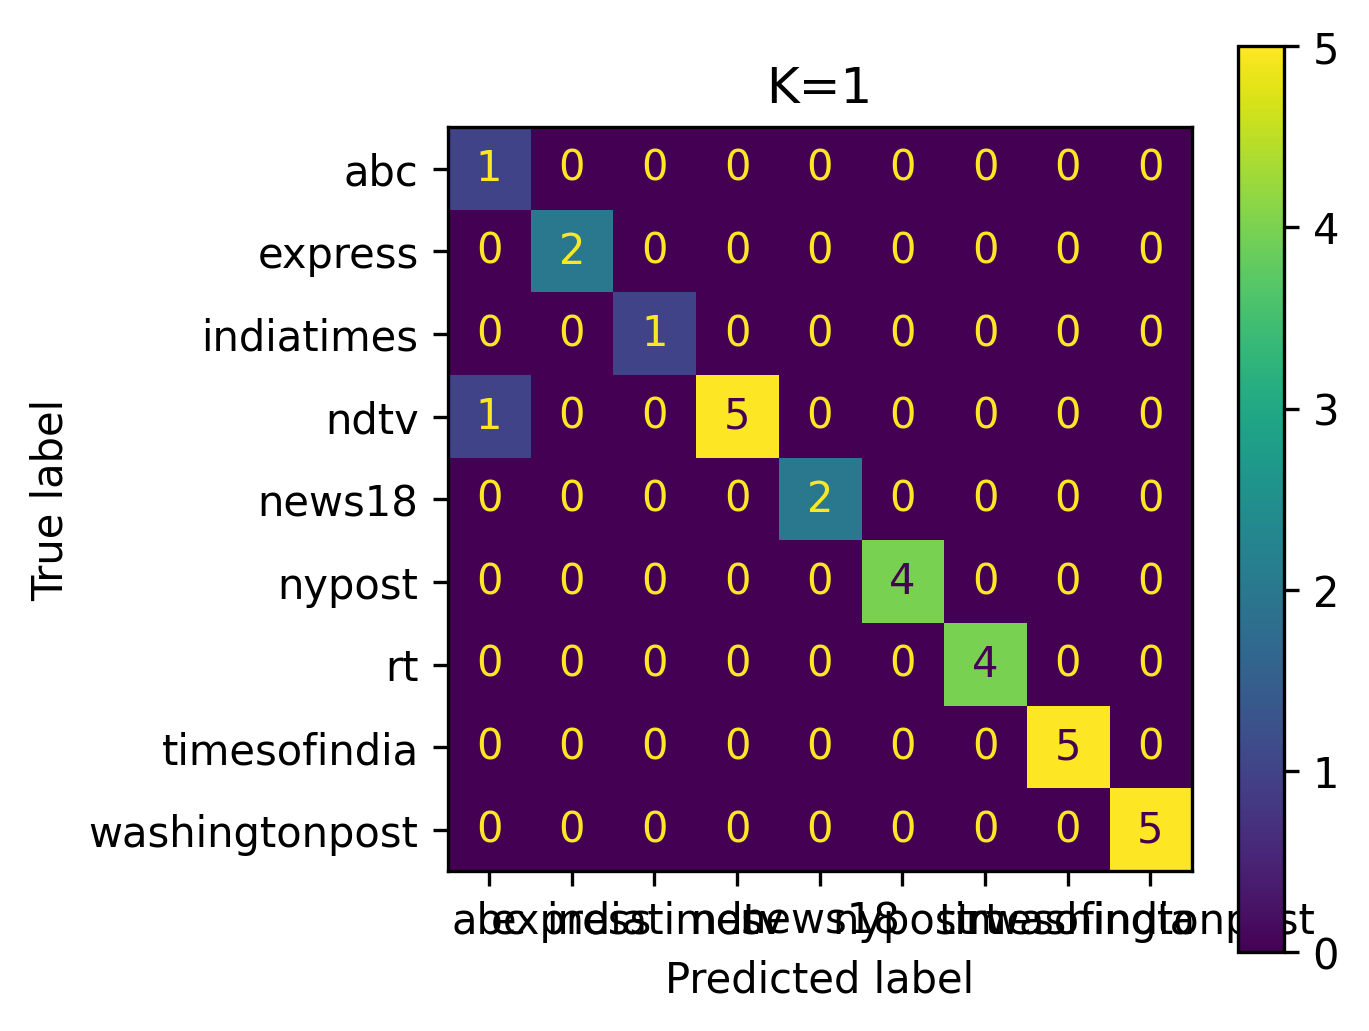

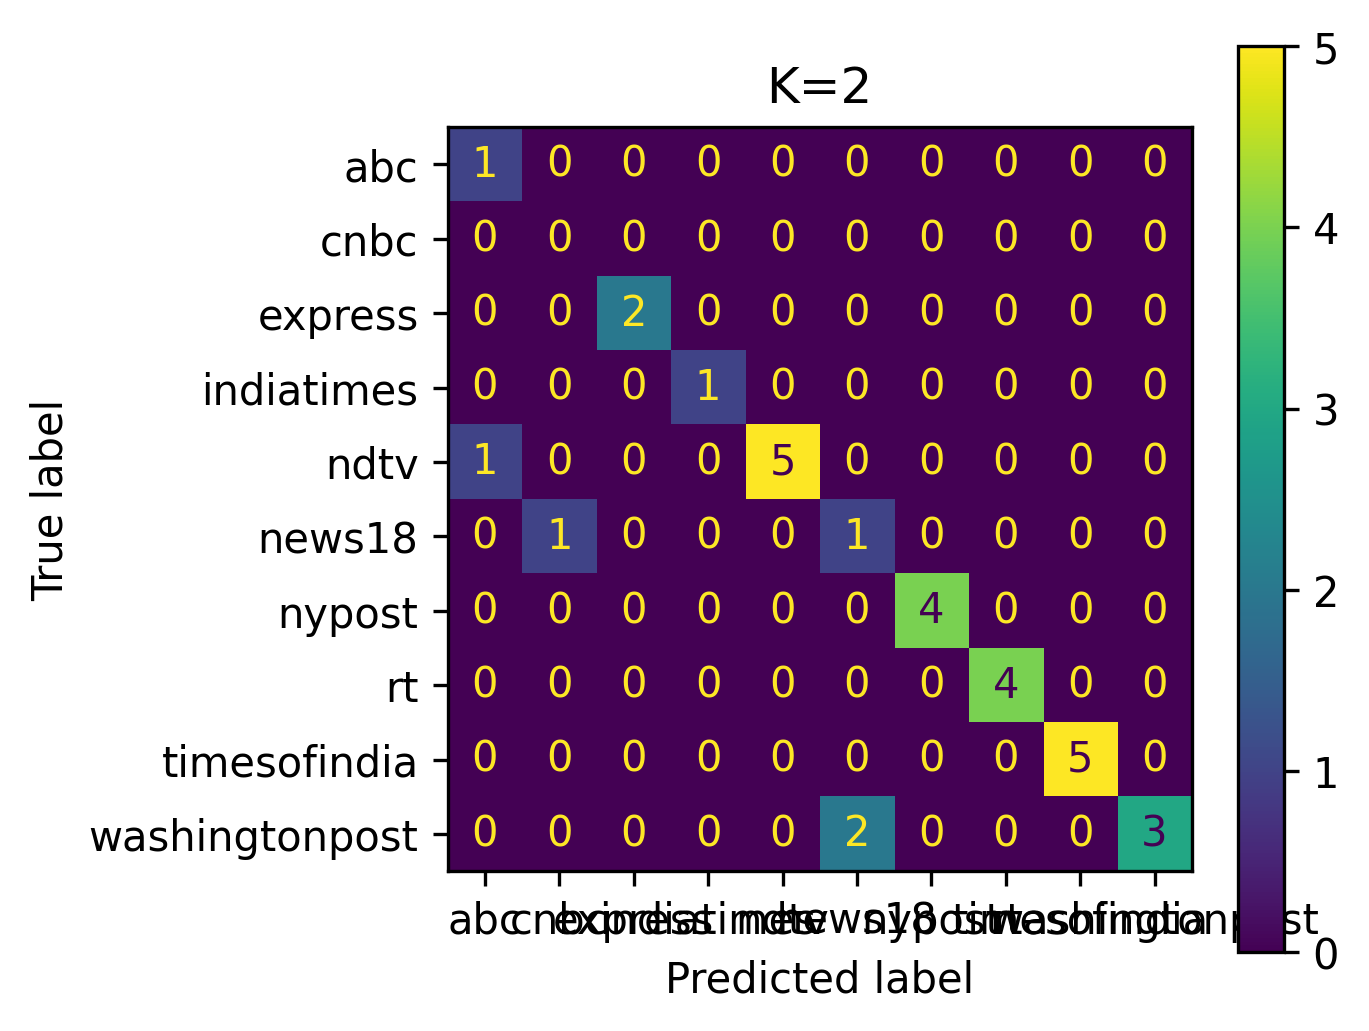

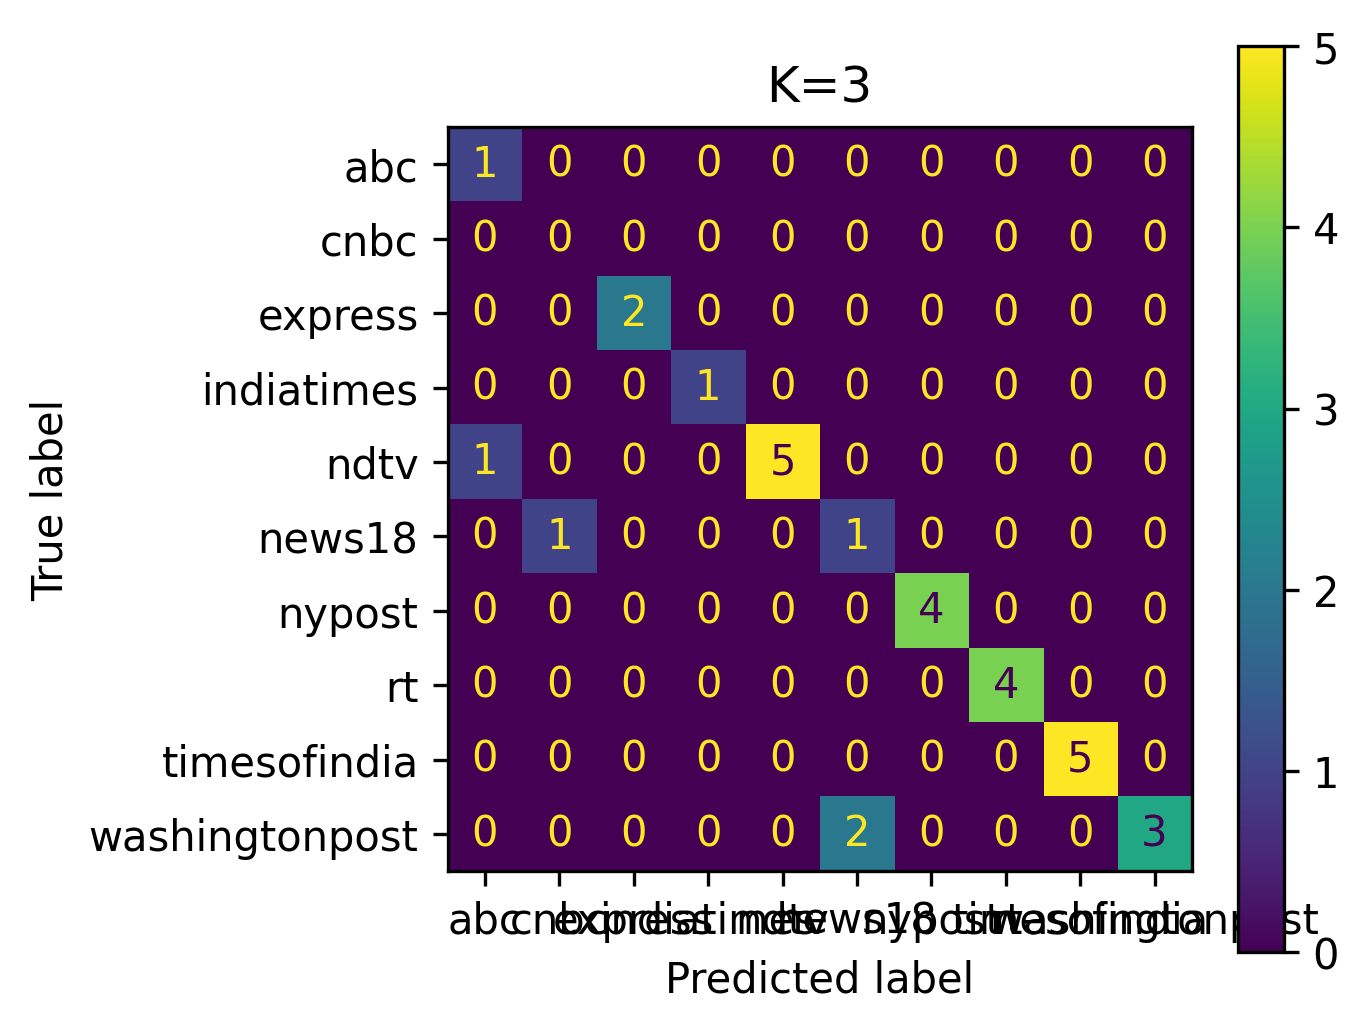

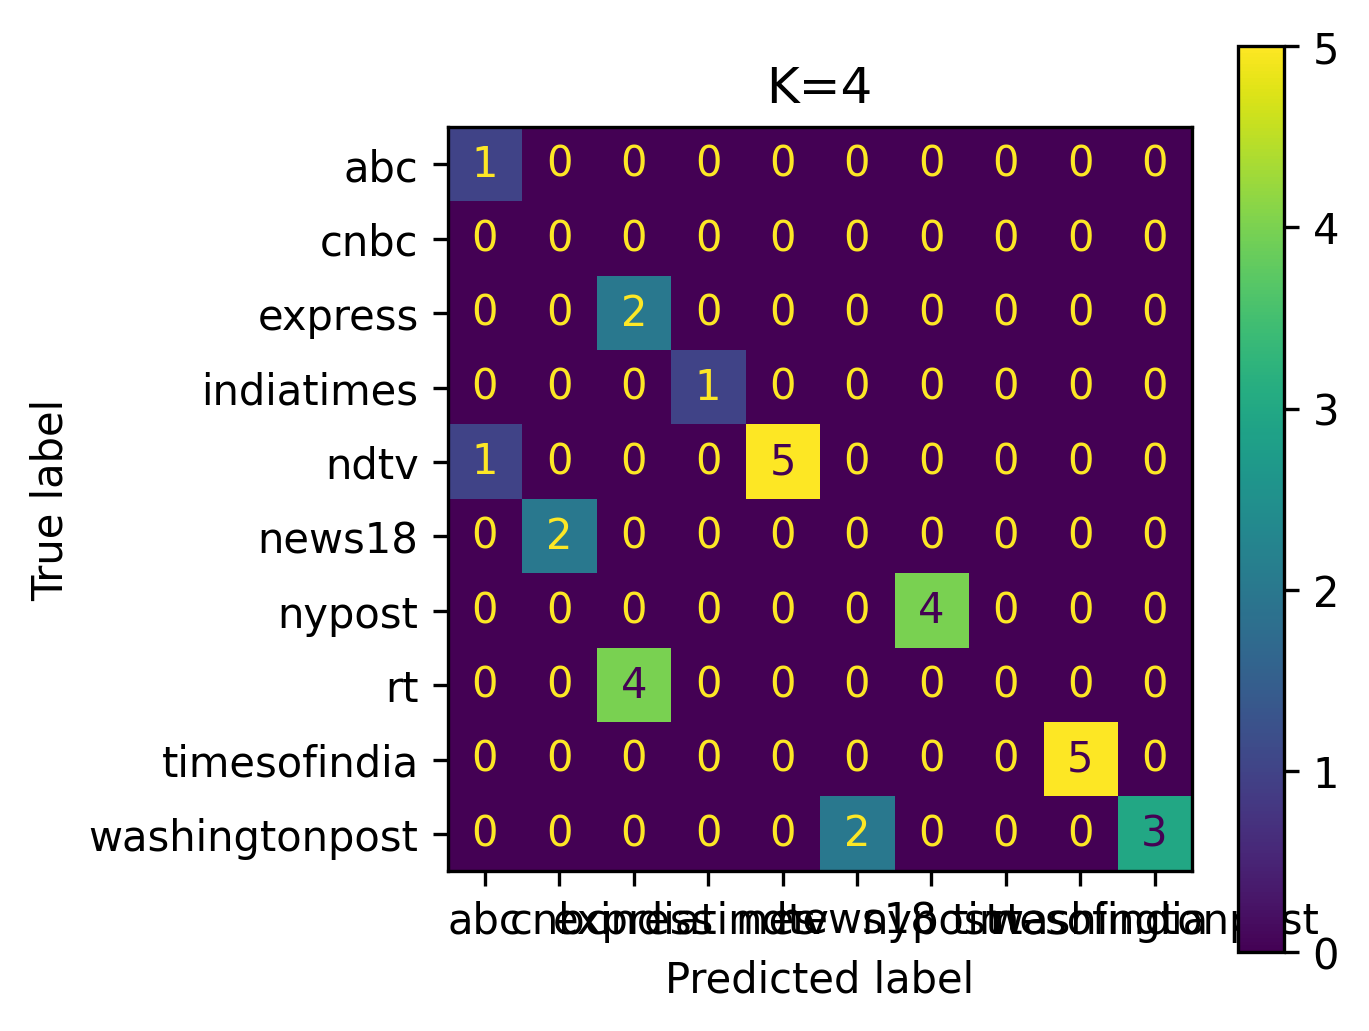

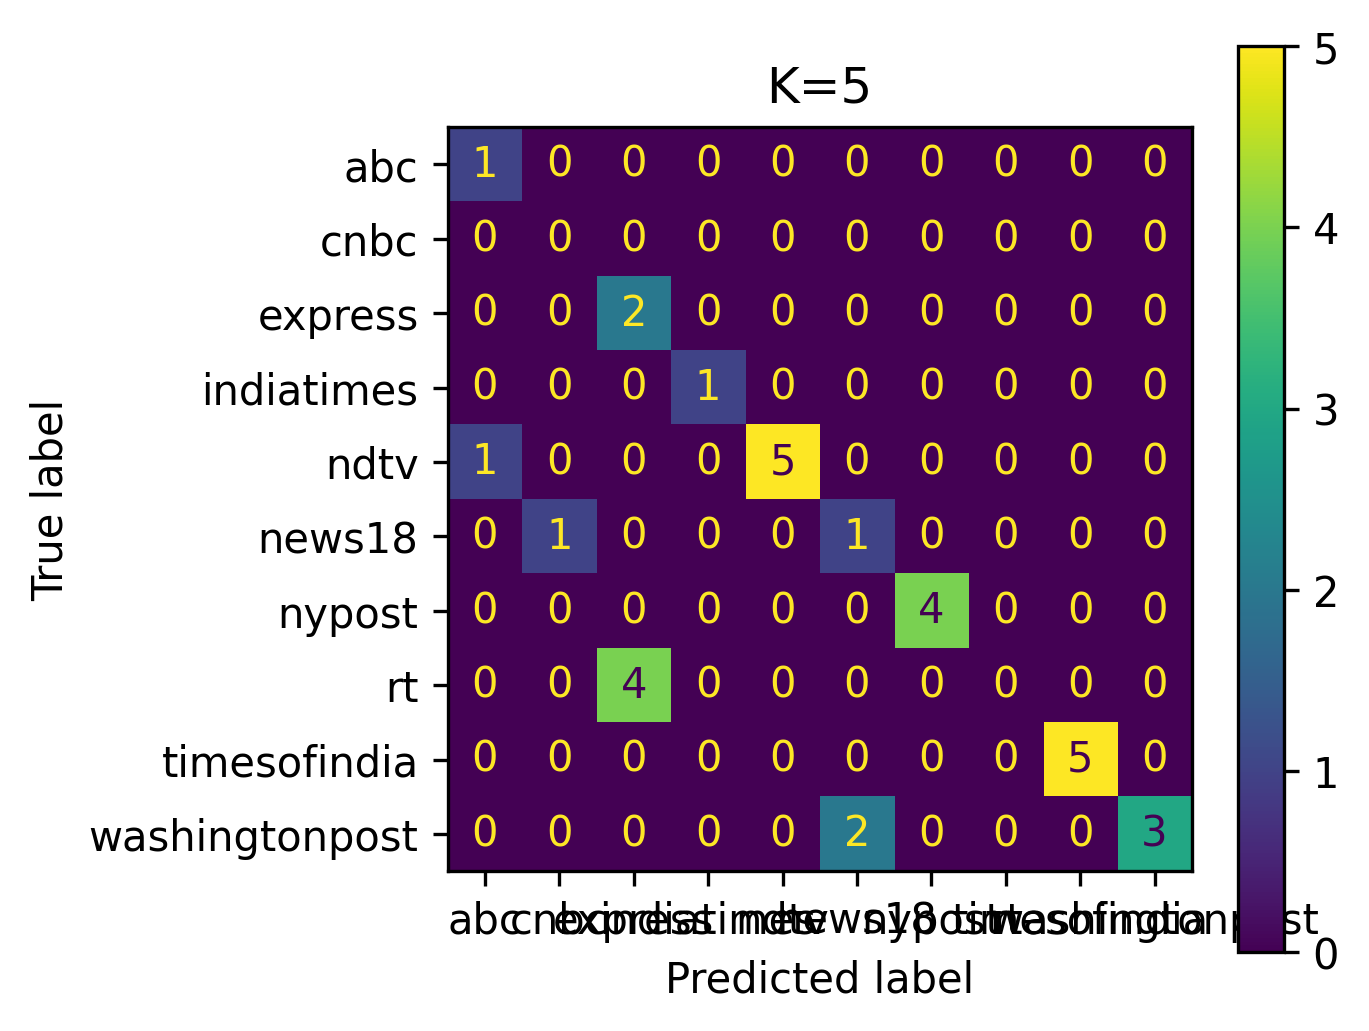

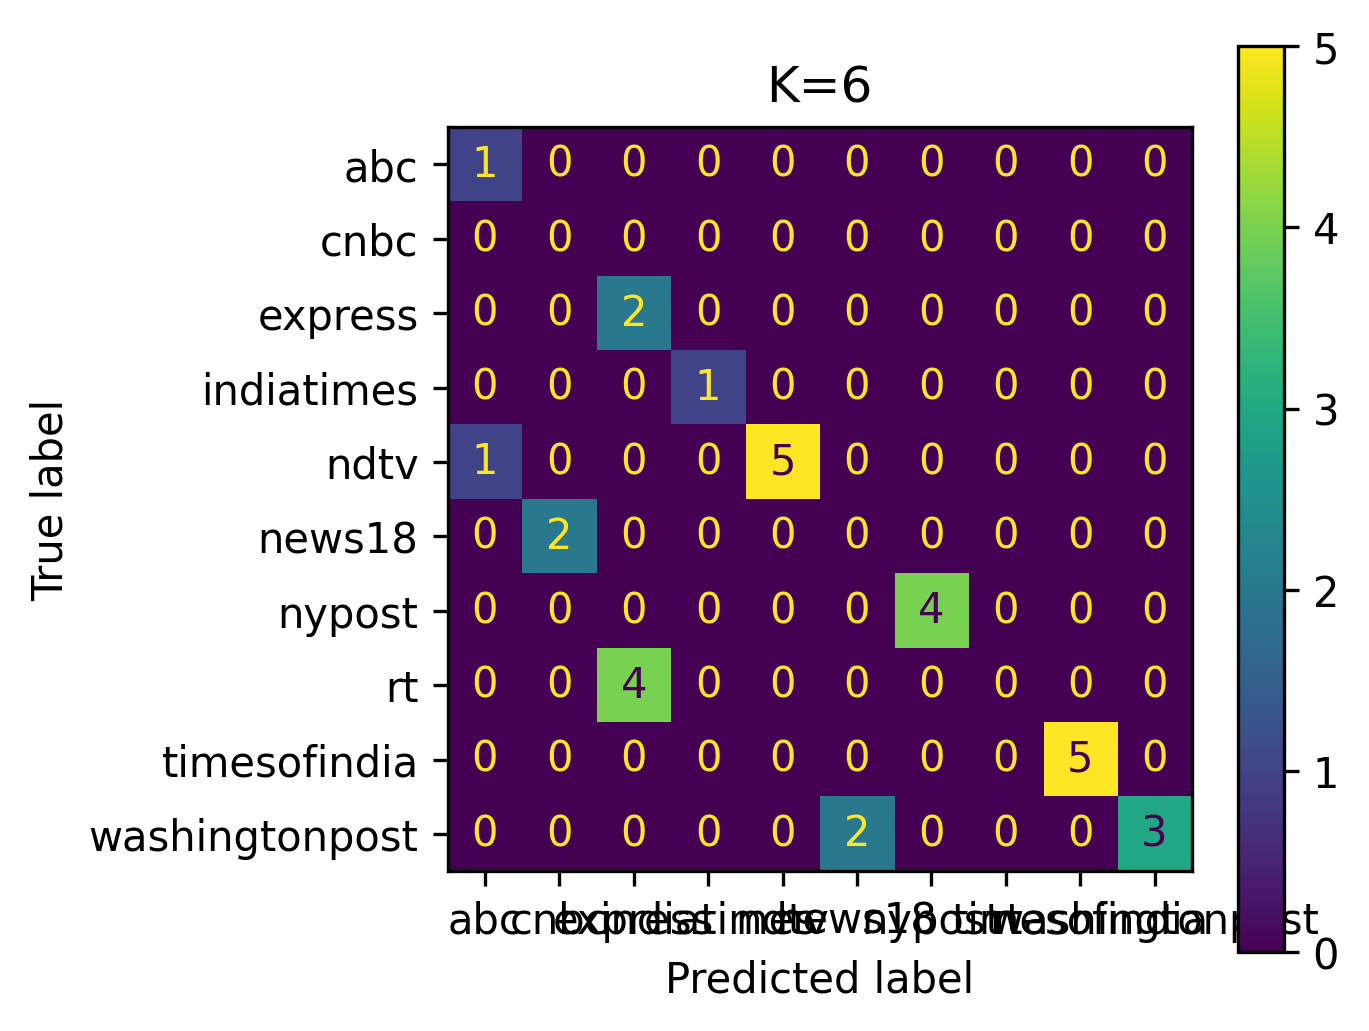

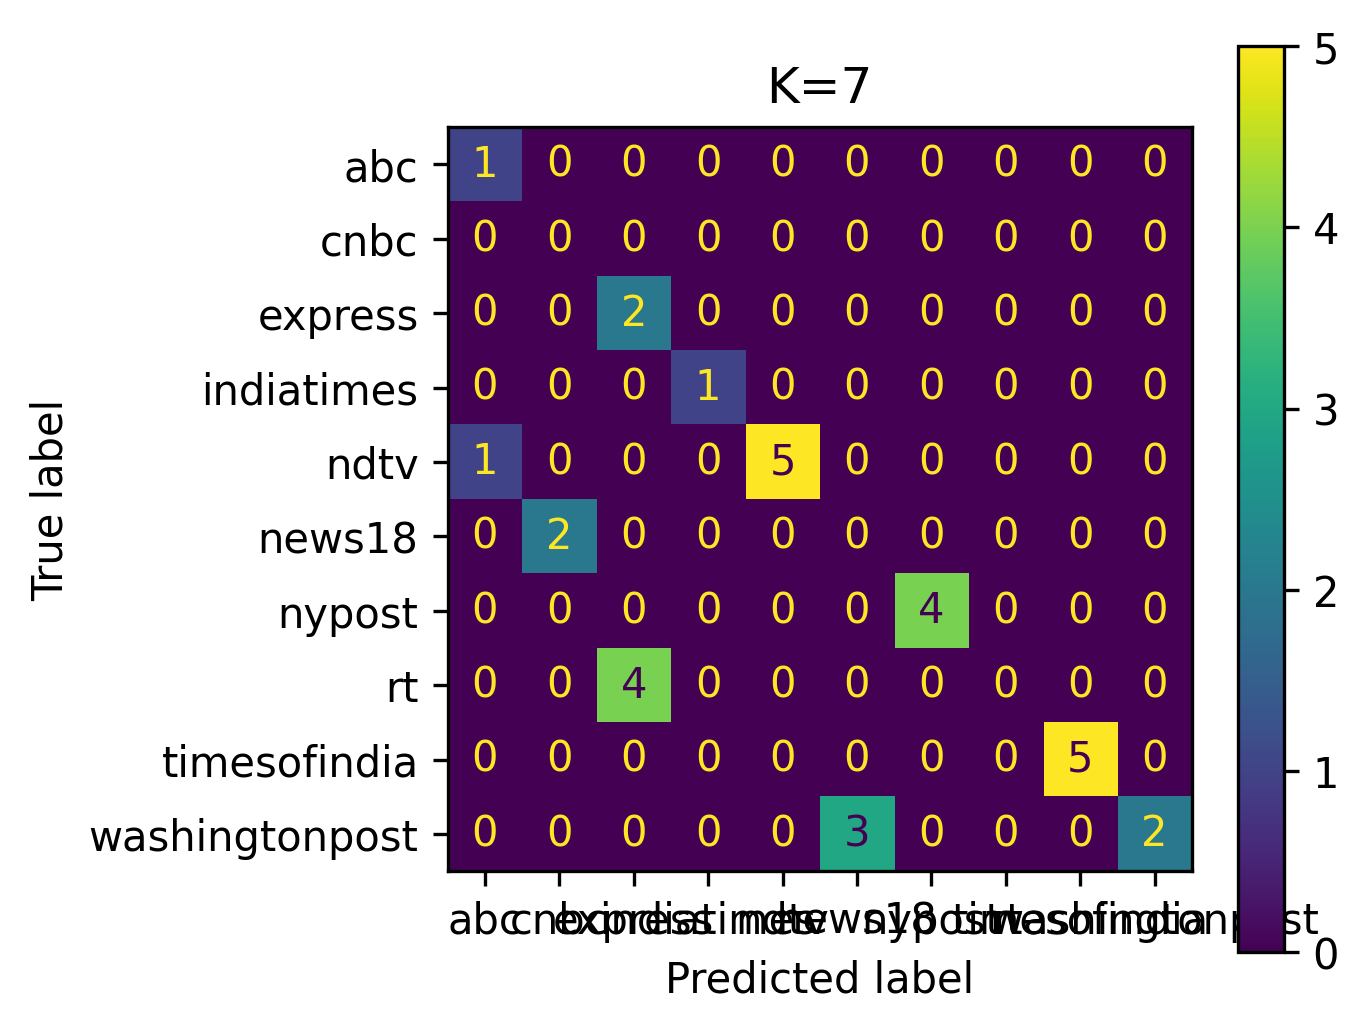

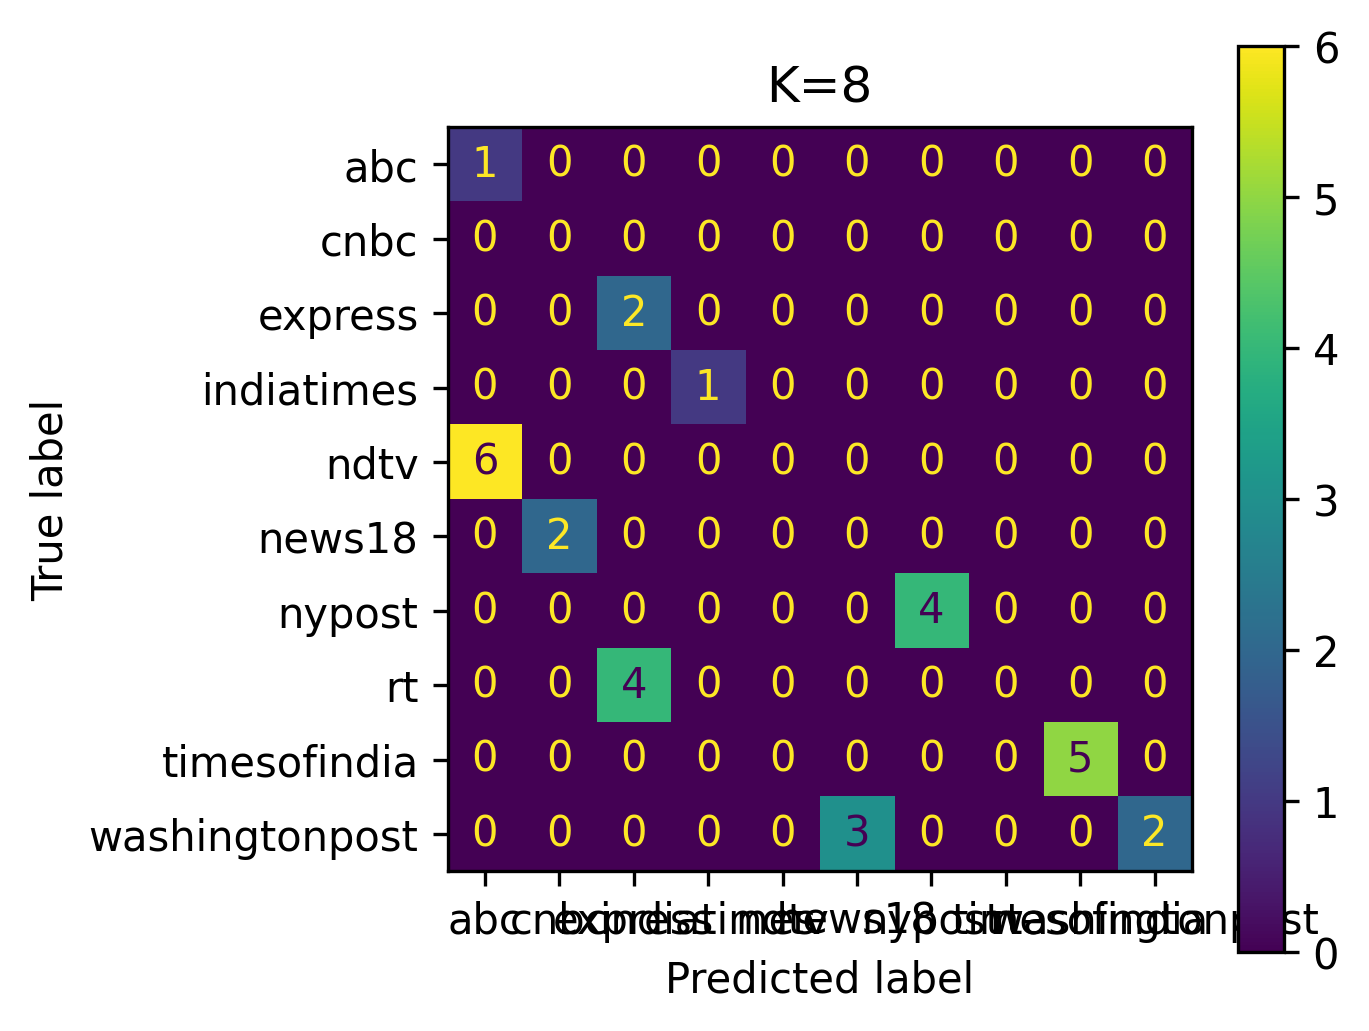

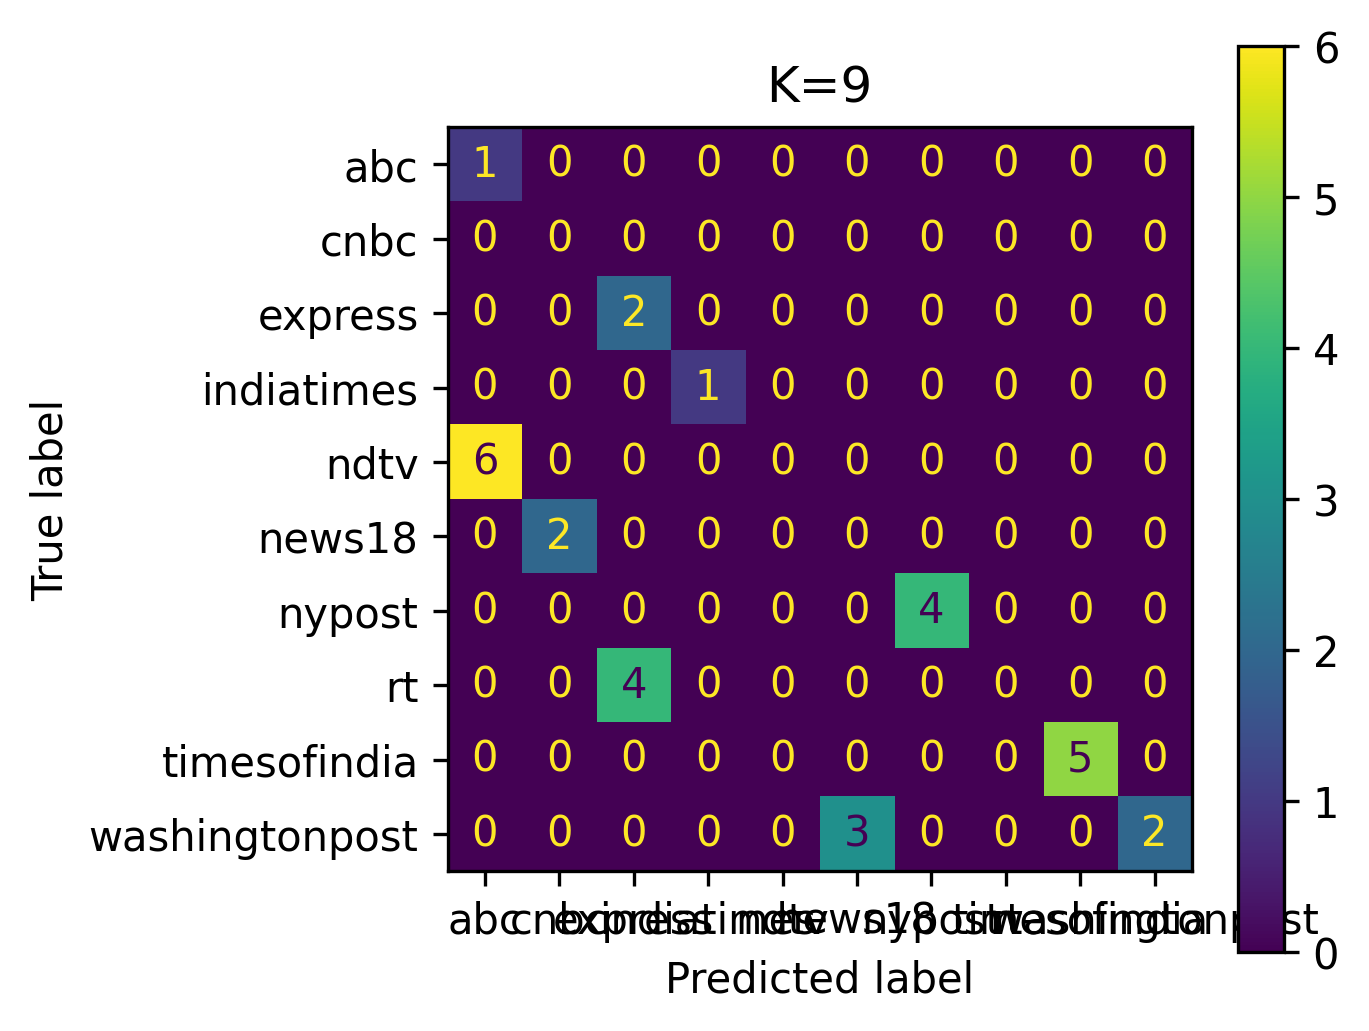

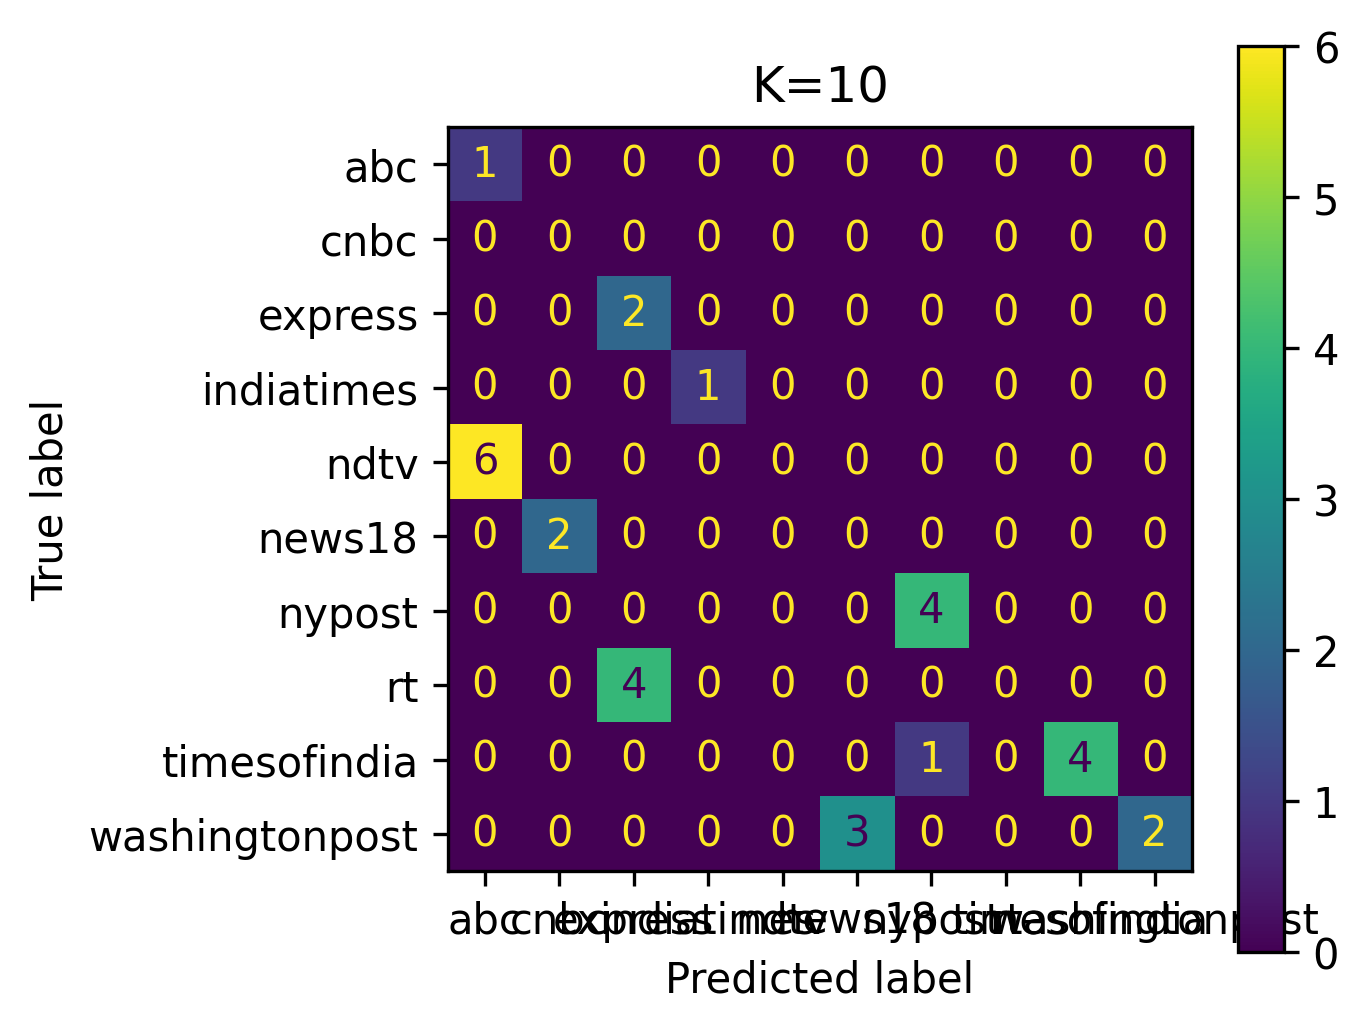

In [ ]:
# to reproduce the results
np.random.seed(1)

# prepare the data
Y_old = result_df1['label']
X_old = result_df1.drop(['s_ip',	's_port',	'd_ip',	'd_port', 'label'],axis=1).dropna().reset_index(drop=True)

X_norm_train_old, X_norm_test_old, Y_train_old, Y_test_old = Stand_Scaler_split(X_old,Y_old)

A_old = KNN(X_norm_train_old, X_norm_test_old, Y_train_old, Y_test_old)

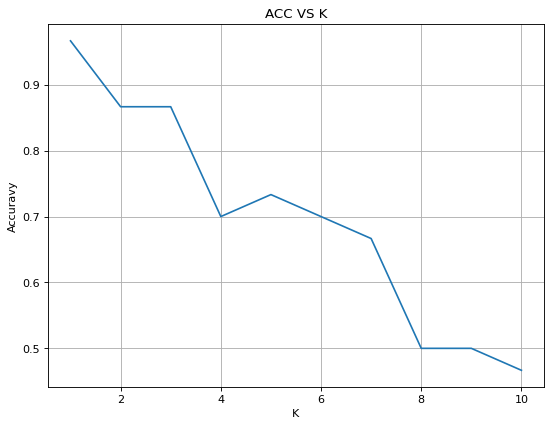

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(range(1,11)),A_old) 

plt.xlabel("K")
plt.ylabel("Accuravy")
plt.grid(visible=True);
plt.title('ACC VS K')
plt.show()

From the plot we can see, that it reasonable to set value of 'K' to 3.

Now we will repeat the experiment with the new data captured approximately a week later and we will refer to it as 'new data' (rerun the 'get_data.sh' and zip it with a name 'data_hw2_new'). The data is highly uncorrelated to the previous one, so we should expect a much woese result.

In [ ]:
# 1 week later!
data_new = '/content/drive/MyDrive/Colab Notebooks/Network measurements /data_hw2_new'
result_df2 = dataset_generator(data_new)
display(result_df2)

s_ip s_port           d_ip d_port  num_packets  total_bytes  \
0   172.28.0.12  42094    23.60.78.89    443          232    1732019.0   
1   172.28.0.12  34136    23.60.78.89    443          290    1736954.0   
2   172.28.0.12  58618    23.60.78.89    443          272    1734684.0   
3   172.28.0.12  44924    23.60.78.89    443          247    1733021.0   
4   172.28.0.12  47838    23.60.78.89    443          261    1733933.0   
..          ...    ...            ...    ...          ...          ...   
94  172.28.0.12  53050  23.60.118.227    443           39      10152.0   
95  172.28.0.12  44896  23.60.118.227    443           37      10031.0   
96  172.28.0.12  46816  23.60.118.227    443           41      10284.0   
97  172.28.0.12  46024  23.60.118.227    443           41      10283.0   
98  172.28.0.12  38746  23.60.118.227    443           35       9899.0   

    mean_pac_size  min_pac_size  max_pac_size  std_pac_size  mean_iat  \
0     7465.599138          54.0       56538.0  14048.648153  0.053897   
1     5989.496552          54.0       56538.0  11173.203018  0.097605   
2     6377.514706          54.0       56538.0  12567.067001  0.085024   
3     7016.279352          54.0       56538.0  13894.060017  0.055118   
4     6643.421456          54.0       56538.0  13070.980716  0.048835   
..            ...           ...           ...           ...       ...   
94     260.307692          54.0        2962.0    541.244188  0.206855   
95     271.108108          54.0        2962.0    553.952103  0.294192   
96     250.829268          54.0        2962.0    529.238788  0.185185   
97     250.804878          54.0        2962.0    529.233135  0.186700   
98     282.828571          54.0        2962.0    568.310783  0.408886   

     min_iat   max_iat   std_iat       label  
0  -0.002789  1.159787  0.148712        cnbc  
1  -0.004888  3.834581  0.354953        cnbc  
2  -0.026107  3.877807  0.344594        cnbc  
3  -0.005198  1.474905  0.160974        cnbc  
4  -0.003791  1.080203  0.142611        cnbc  
..       ...       ...       ...         ...  
94 -0.002003  1.122499  0.383737  indiatimes  
95 -0.001907  1.799512  0.526631  indiatimes  
96 -0.002289  1.108313  0.355113  indiatimes  
97 -0.004697  1.096892  0.346730  indiatimes  
98 -0.003600  5.688000  1.018138  indiatimes  

[99 rows x 15 columns]

Accuracy for K= 1 : 0.6333333333333333
Accuracy for K= 2 : 0.5666666666666667
Accuracy for K= 3 : 0.6
Accuracy for K= 4 : 0.5
Accuracy for K= 5 : 0.4666666666666667
Accuracy for K= 6 : 0.5
Accuracy for K= 7 : 0.5
Accuracy for K= 8 : 0.5
Accuracy for K= 9 : 0.5
Accuracy for K= 10 : 0.5666666666666667


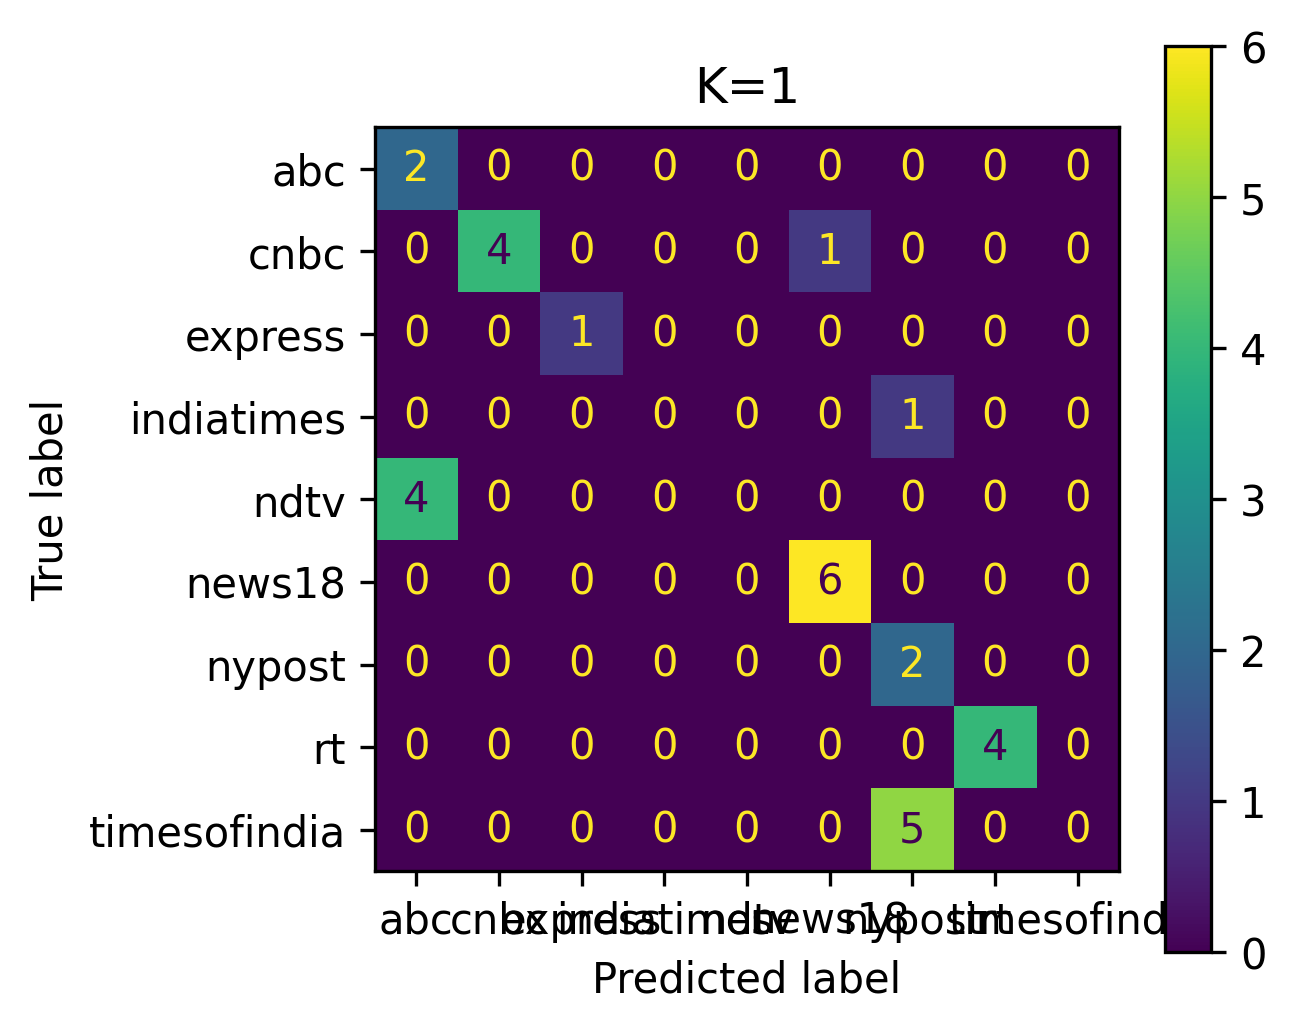

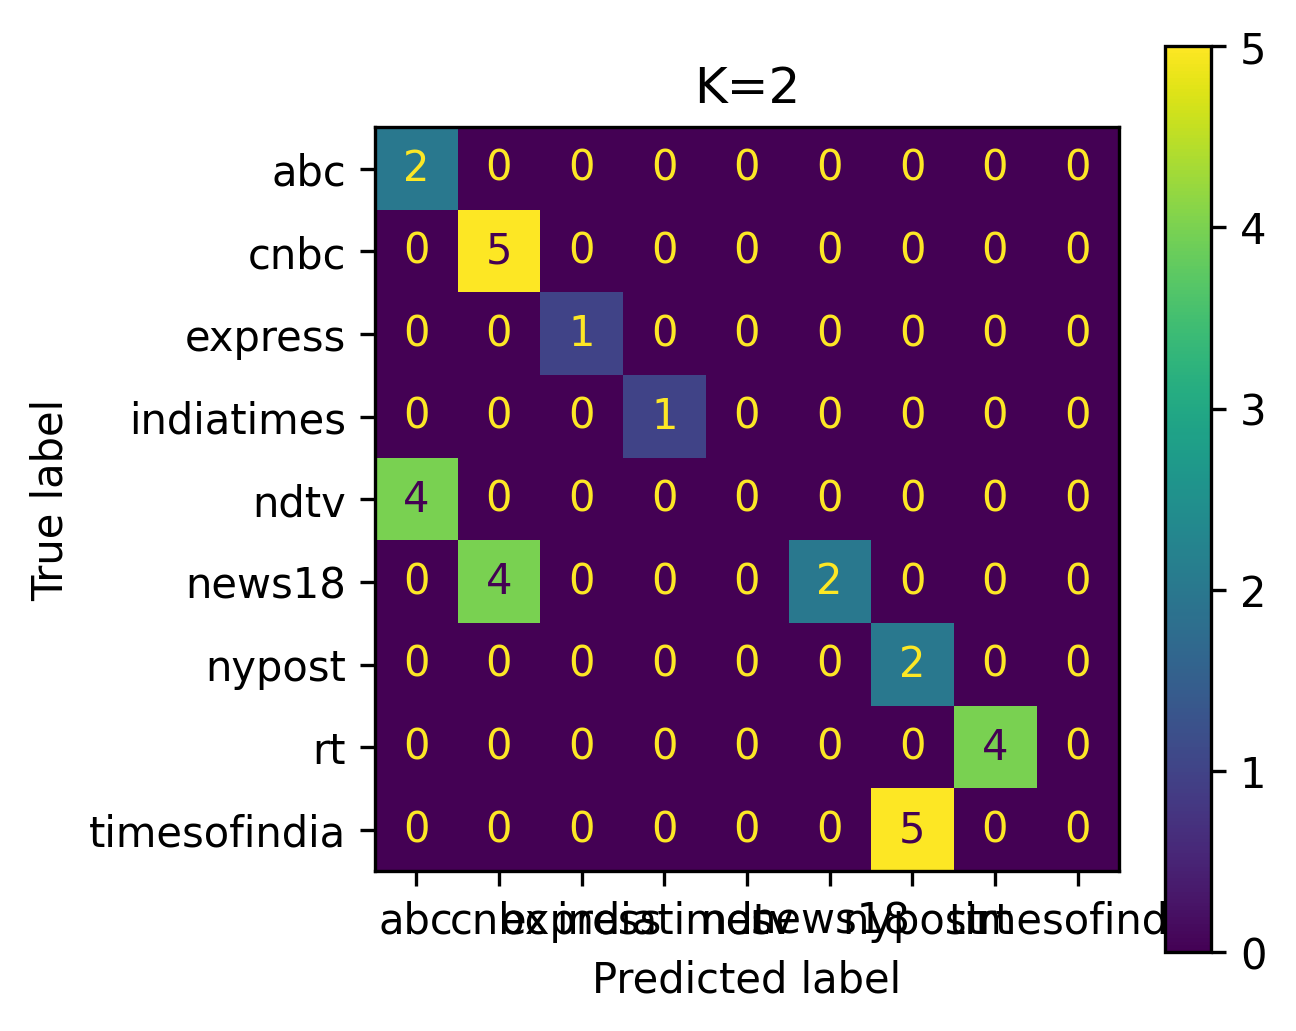

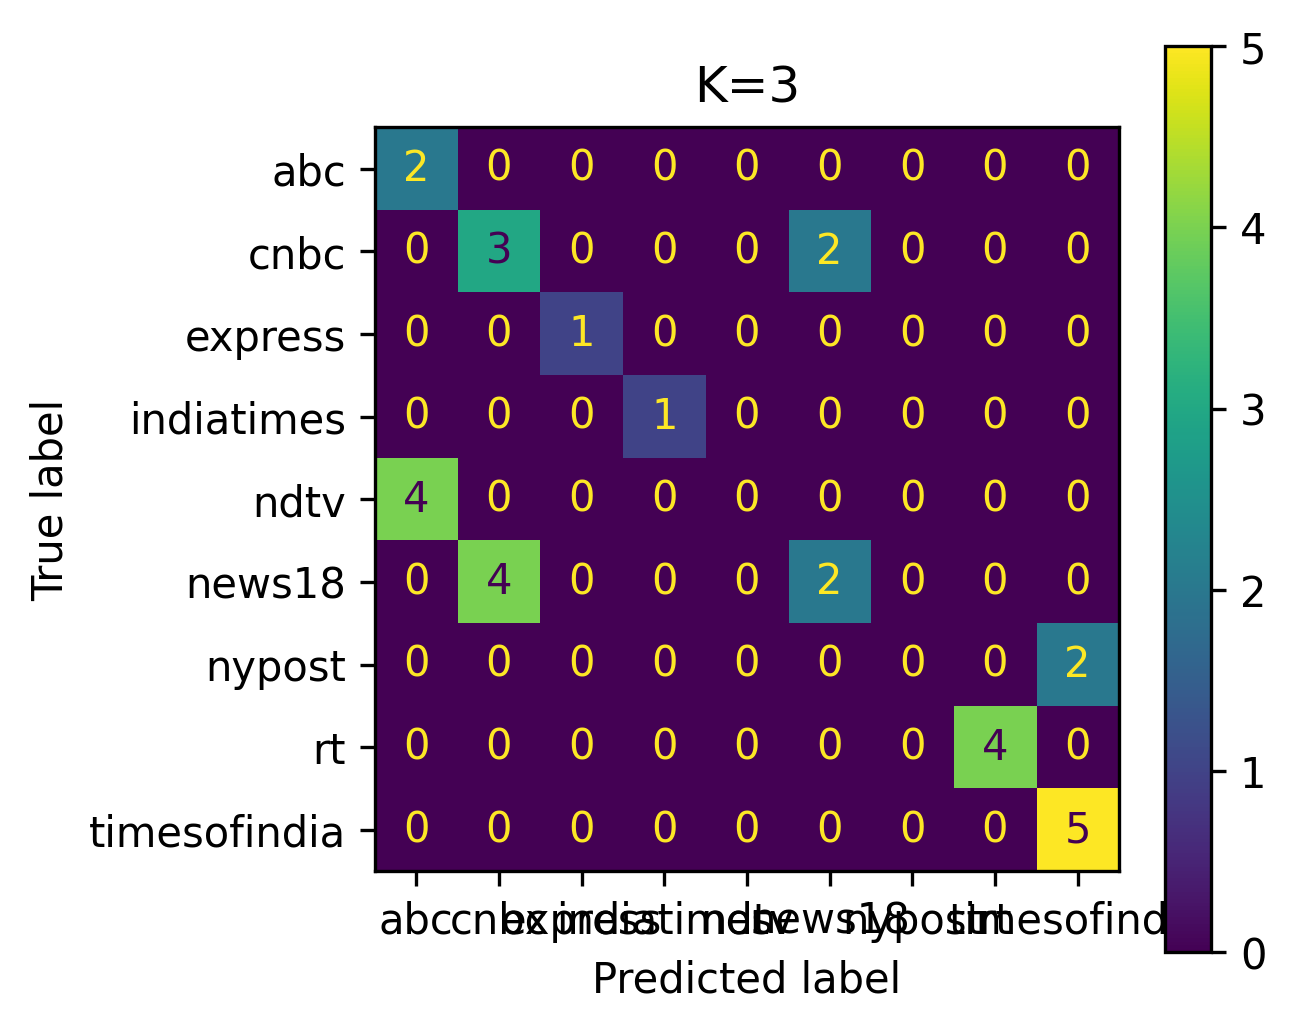

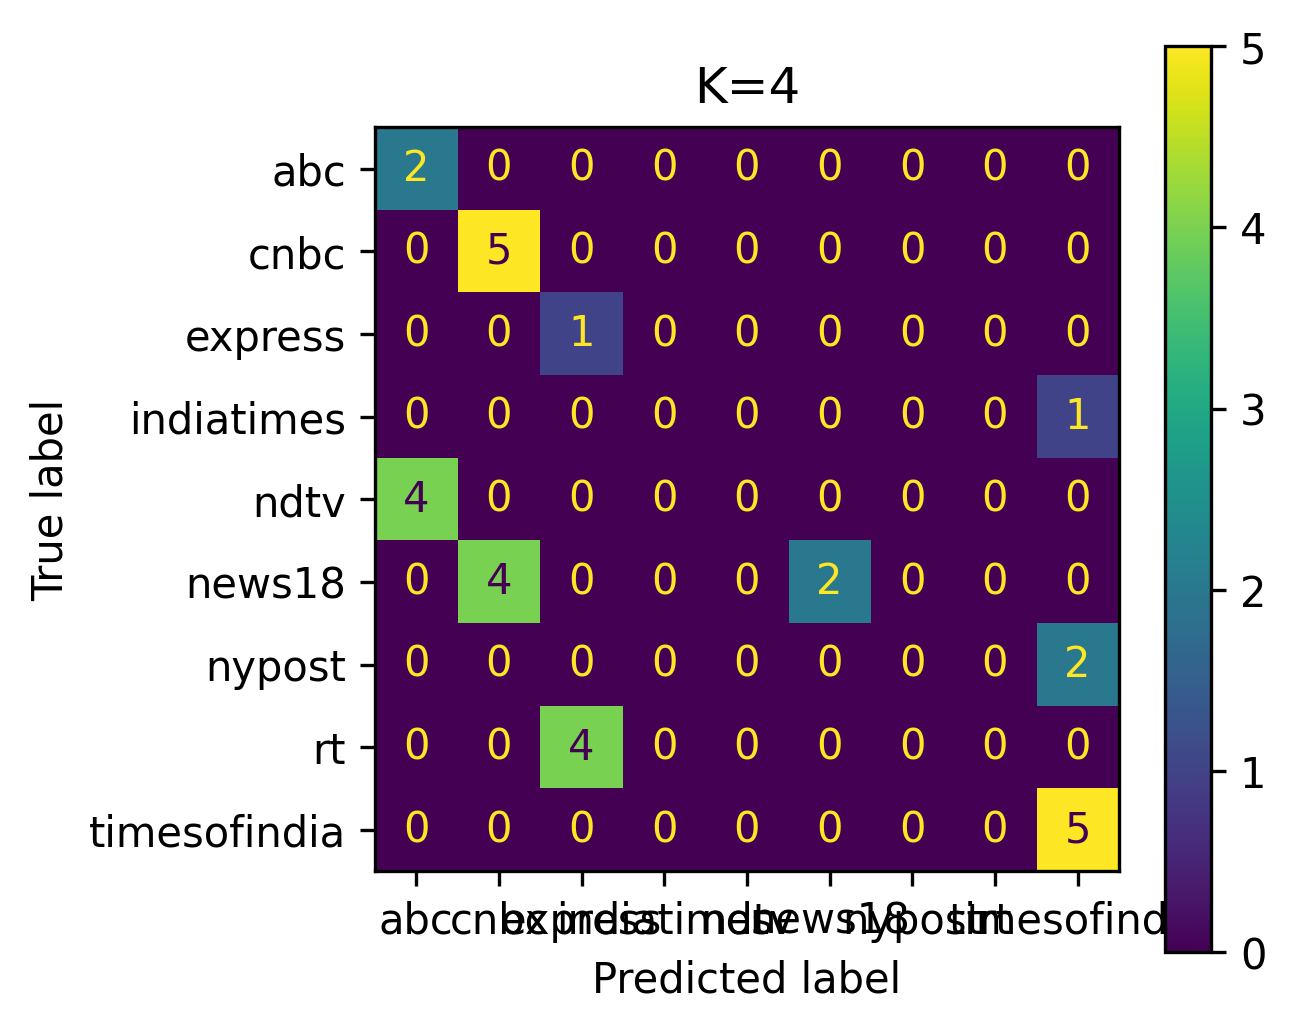

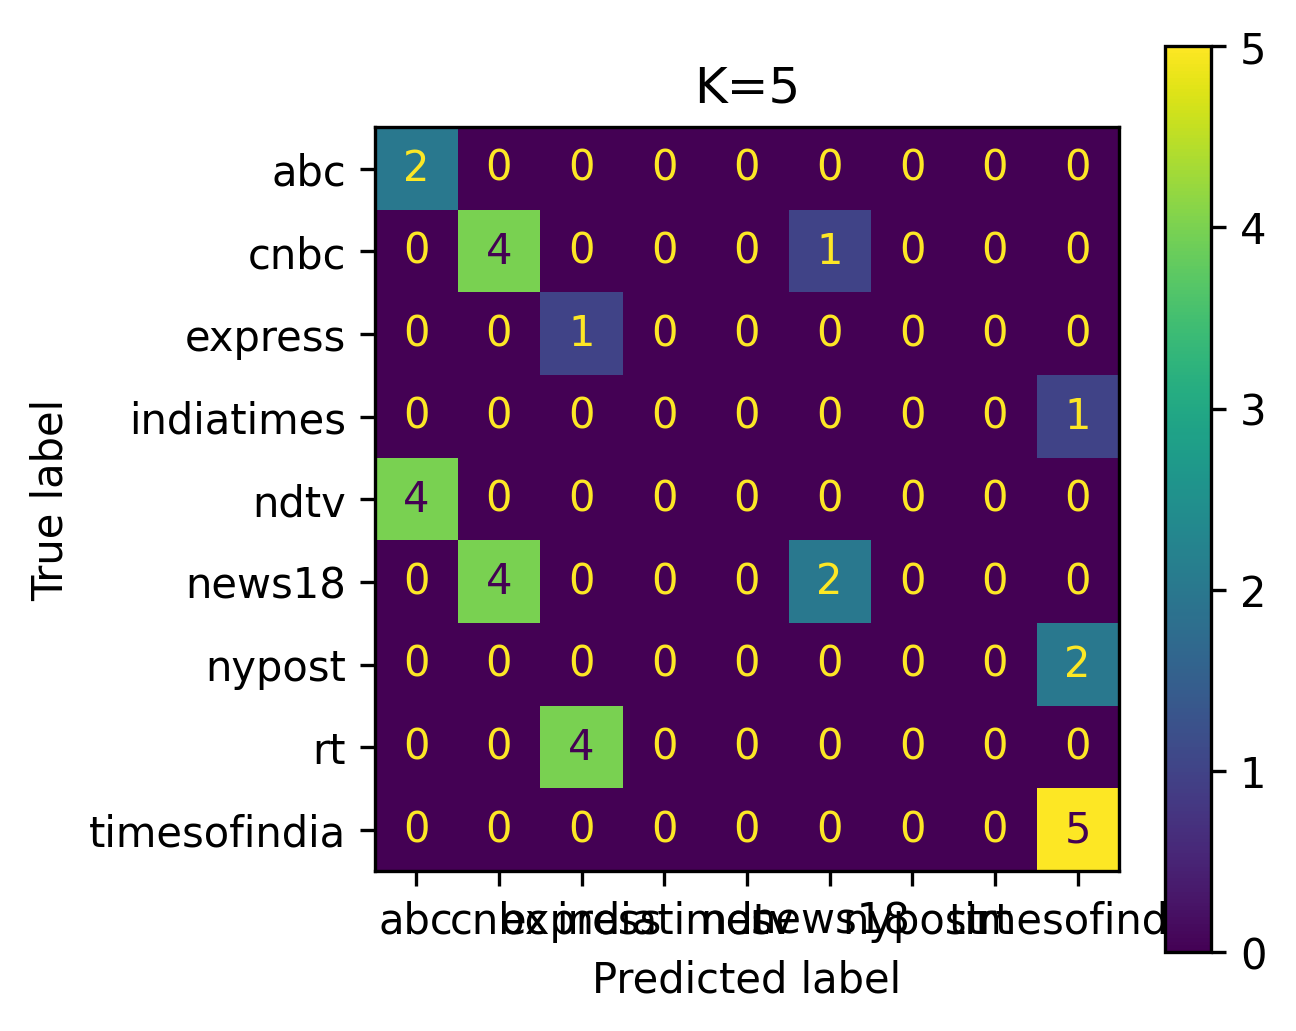

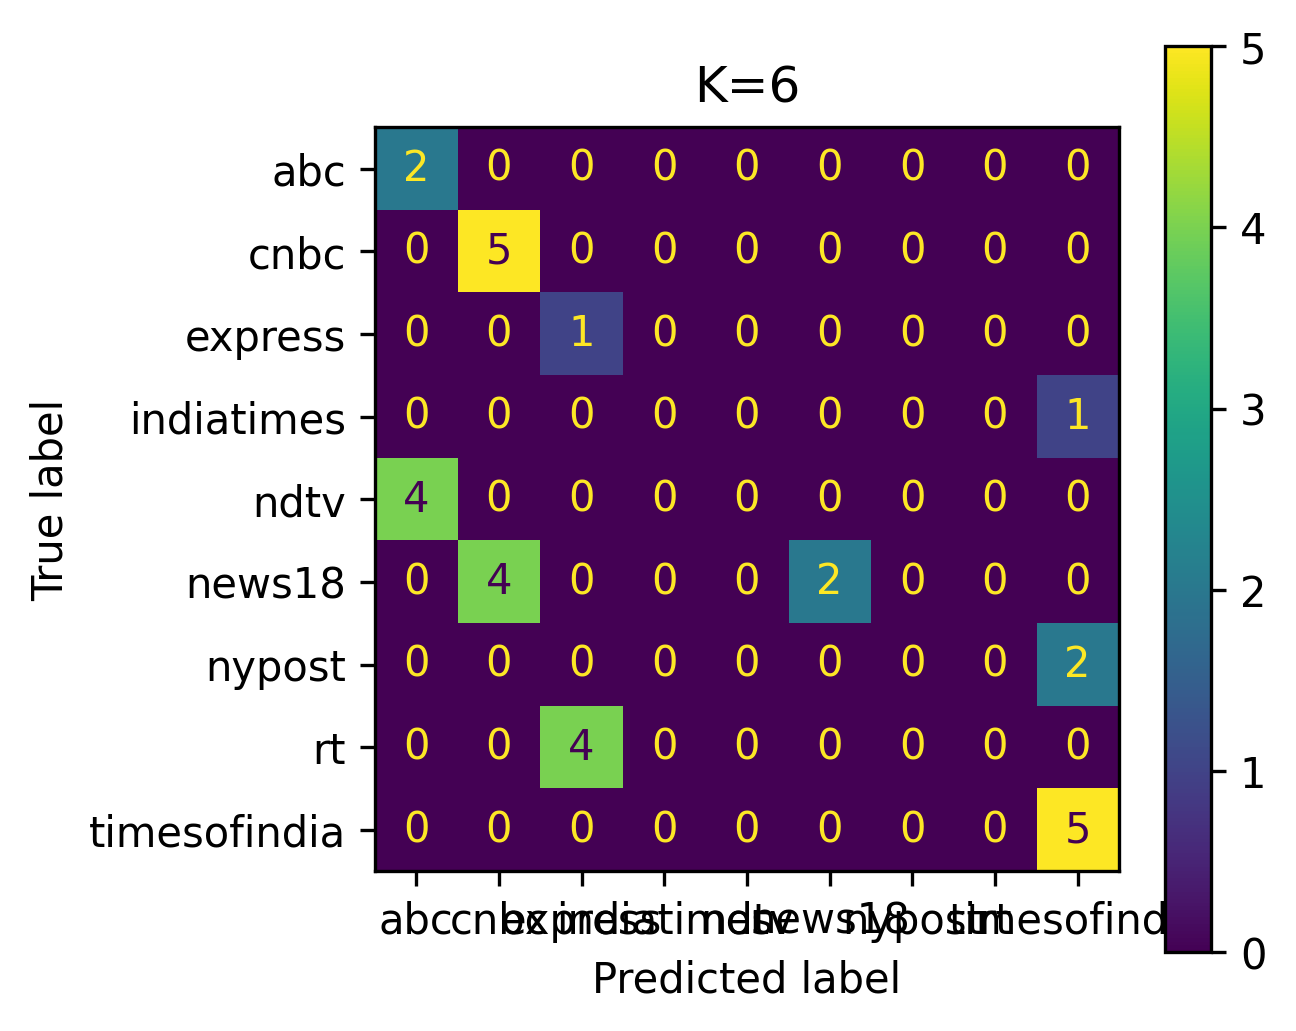

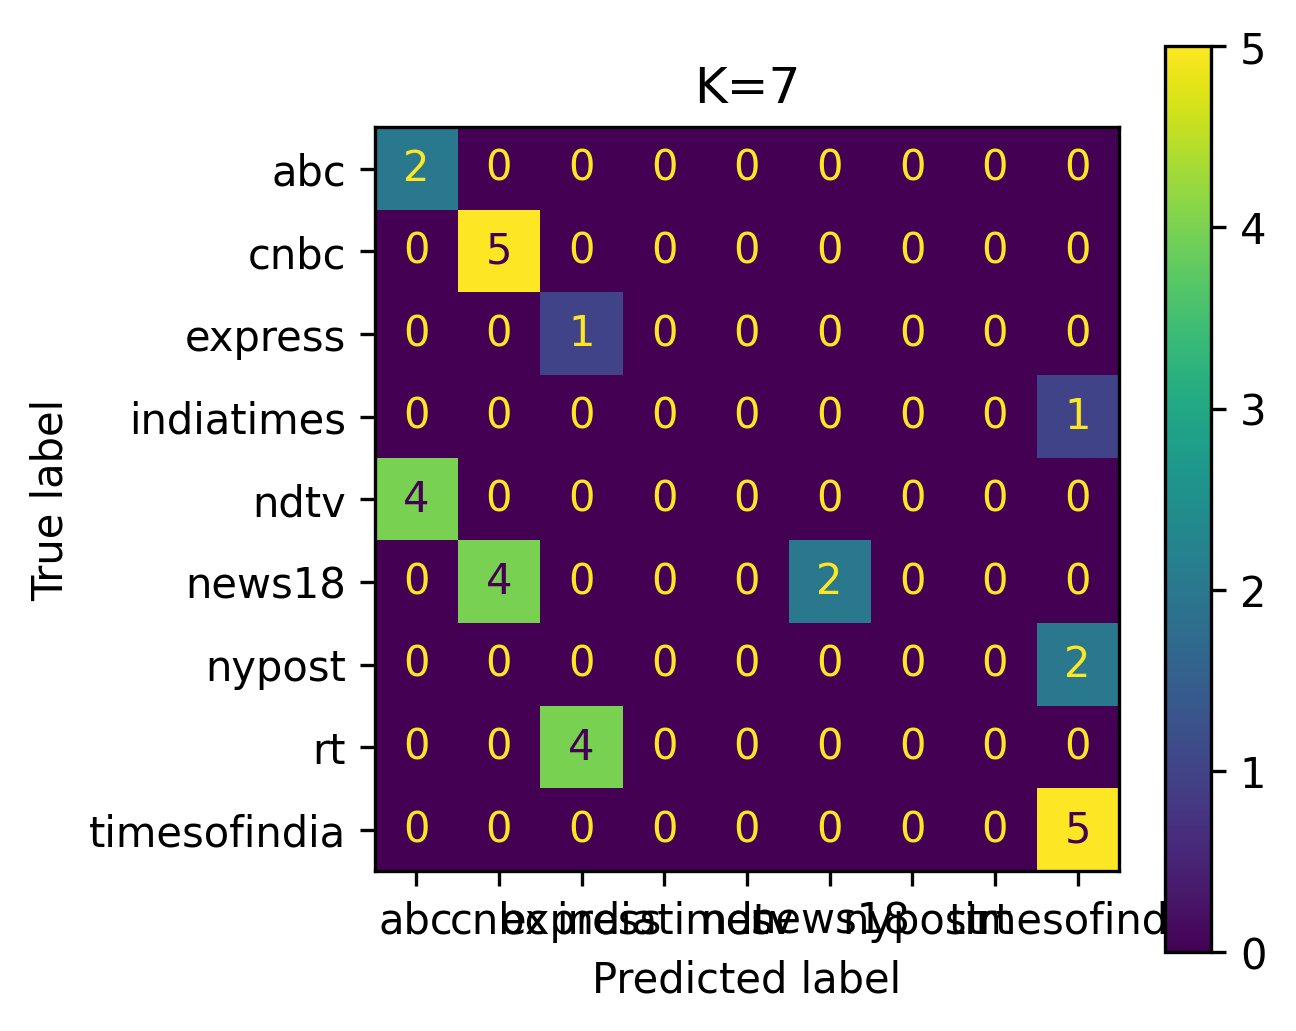

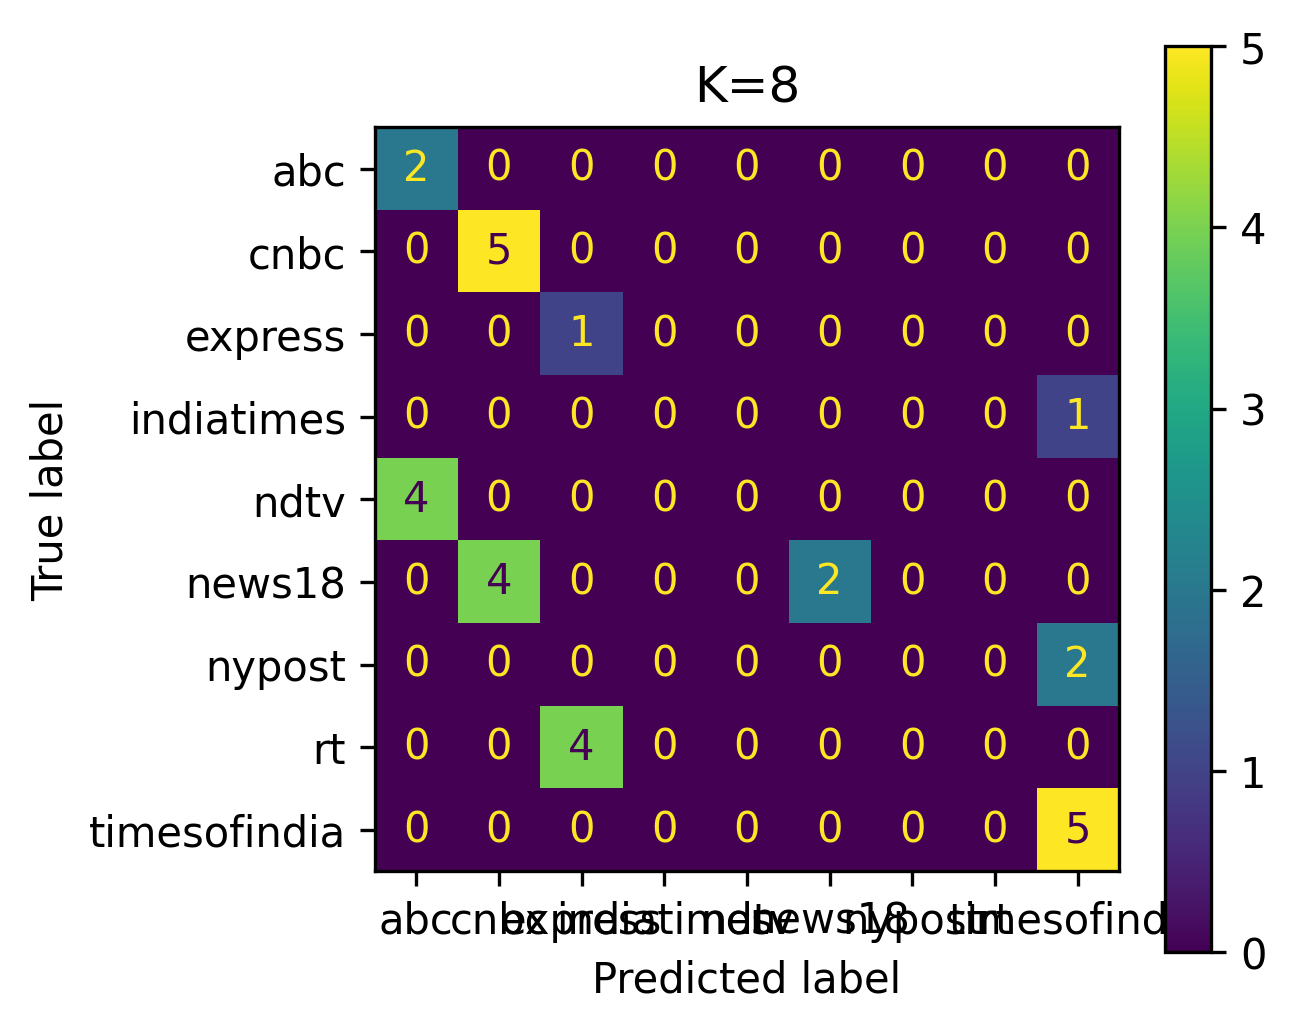

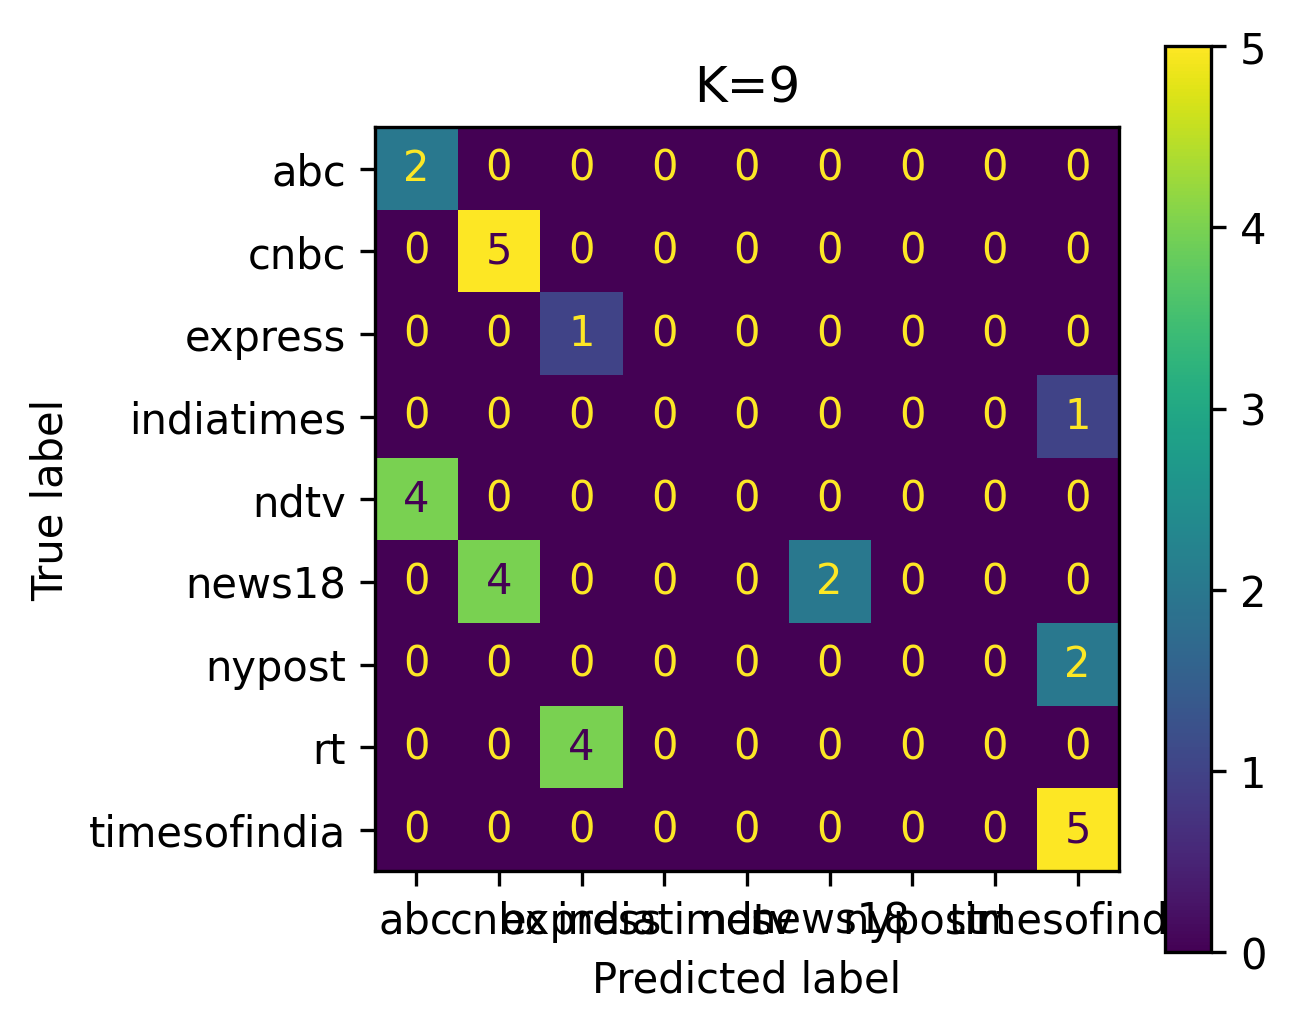

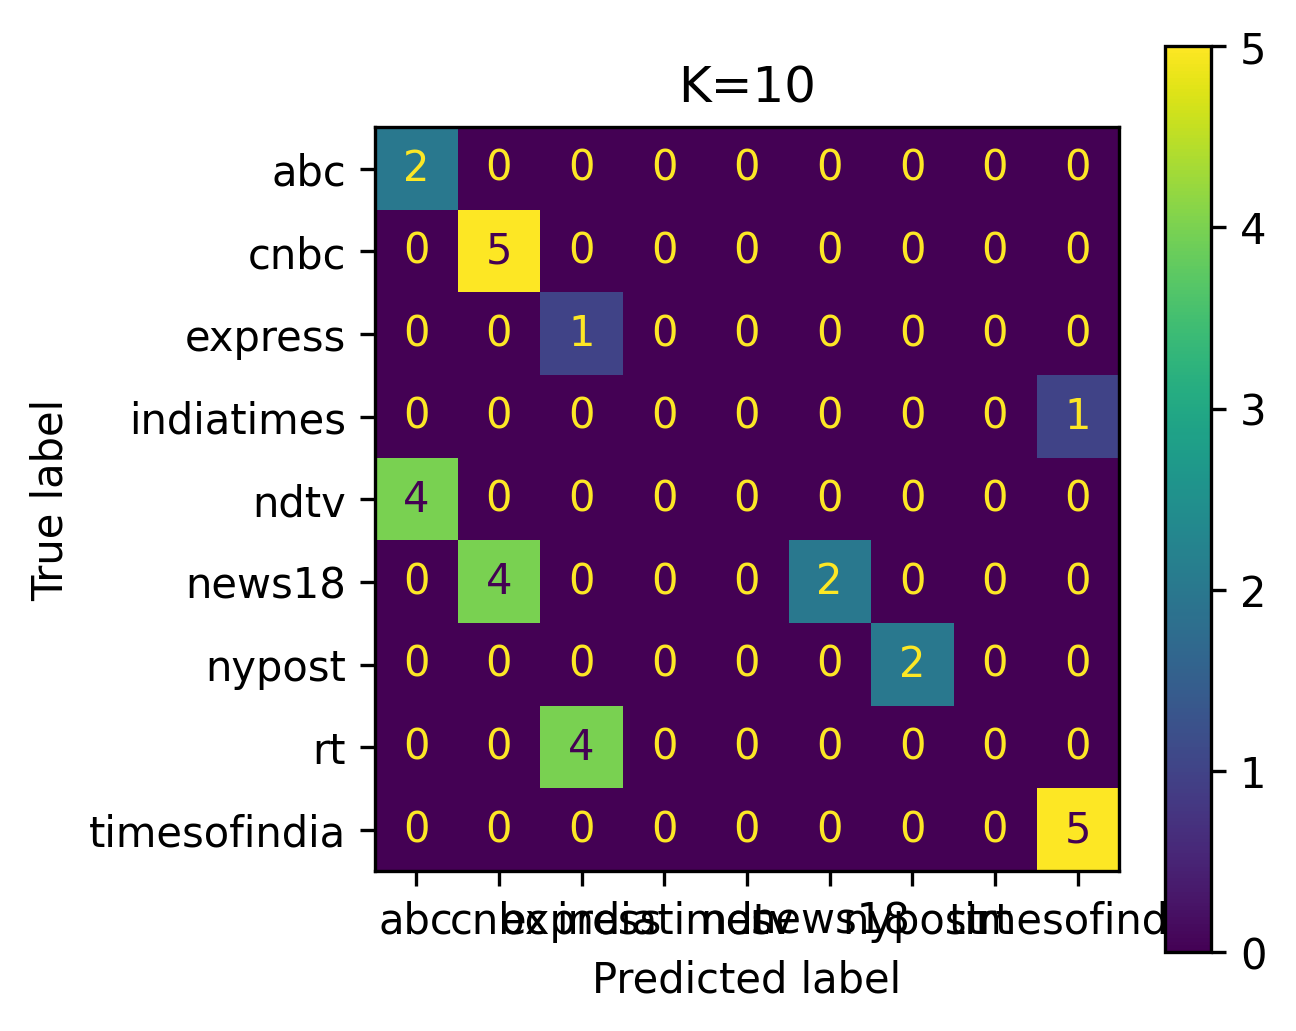

In [ ]:
#to repriduce the results
np.random.seed(1)

Y_new = result_df2['label']
X_new = result_df2.drop(['s_ip',	's_port',	'd_ip',	'd_port', 'label'],axis=1).dropna().reset_index(drop=True)

X_norm_train_new, X_norm_test_new, Y_train_new, Y_test_new = Stand_Scaler_split(X_new,Y_new)

# we train on the old train data, but we use new test data
A_new = KNN(X_norm_train_old, X_norm_test_new, Y_train_old, Y_test_new)

We can see that the result when the model is trained on the old data and tested on the new data is significantly worse wrt the exaple when old data is used for both steps.

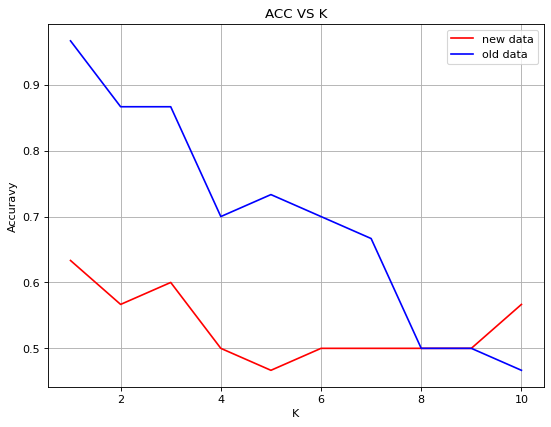

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(range(1,11)),A_new, 'r') 
plt.plot(list(range(1,11)),A_old, 'b') 

plt.xlabel("K")
plt.ylabel("Accuravy")
plt.grid(visible=True);
plt.title('ACC VS K')
plt.legend(['new data', 'old data'])
plt.show()

We can obeserve, that ever since the site was updated (news on the webpage), the performance has decreased significantly. We can also observe that the best choice of the number of neighbours would indeed be 3.


Now we will repeat the experiment with a different fingerprinting method using the old data for training and testing, and old data for training and new data for testing. We will compare the results with statistical-features-based method used previously. The following cell has a simmilar structure as before. Here when we generate the dataset we follow the same procedure, but we also add a label which indicates wether we have an outgoing or an incoming packet. To remove the unnecessary ACKs, we, basically, say, that we need non-ACKs or ACKs which are large enough.  Then we extract the features the way it is proposed in the article (substractiing or summing packet lengths depending on source) and return 20 equidistant points using liniar interpolation.


In [ ]:
def extract_features_fingerprinting(flow, df,M):
    cumulative_trace = np.zeros(len(df)+1)
    
    for i, row in df.iterrows():
        if row['direction'] == 'incoming':#sum the packet length
            cumulative_trace[i+1] = cumulative_trace[i] + np.float64(row['packet.length'])
        else: #sbstract the packet length
            cumulative_trace[i+1] = cumulative_trace[i] - np.float64(row['packet.length'])
    x = np.linspace(0, len(cumulative_trace)-1, M, endpoint = False)# 20 equidistant points
    interp_cumulative_trace = interp1d(np.arange(len(cumulative_trace)), cumulative_trace)(x)
    return interp_cumulative_trace

def dataset_generator_fingerprinting(M, directory):

    result_df = pd.DataFrame()
    folders = [f for f in os.listdir(directory) if f.startswith('www.')] #avoid default folders

    for folder_ in folders:
        folder_path = os.path.join(directory, folder_)

        #label is, basically, www.{label}.com
        label = folder_.split('.')[1]

        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]#make sure it is a file

        #for every file in a folder
        for file_ in files:
          file_path = os.path.join(folder_path, file_)
          
          #create a df
          df = pd.DataFrame()      
          nest_asyncio.apply()
          
          # Extract packets from the pcap file and remove TCP ACK packets 
          cap = pyshark.FileCapture(file_path, display_filter='tcp.flags.ack==0 || (tcp.flags.ack==1 && frame.len>=100)')
          
          for packet in cap:
              new_row = {'packet.ip.src':packet.ip.src, 
                          'packet.tcp.srcport':packet.tcp.srcport, 
                          'packet.ip.dst':packet.ip.dst, 
                          'packet.tcp.dstport':packet.tcp.dstport,
                          'packet.length':packet.length,
                          'direction':'outgoing' if packet.ip.src == '172.28.0.12' else 'incoming'} 
                # Extract the packet length and direction based on the source IP address
                
              df = df.append(new_row, ignore_index = True)
          # Close the capture
          cap.close()

          for index, row in df.iterrows():#FOR FURTHER AGGREAGATION OF UPLINK AND DOUNLINK
              if row['packet.ip.src'] !='172.28.0.12':
                  temp = row['packet.ip.src']
                  row['packet.ip.src'] = row['packet.ip.dst']
                  row['packet.ip.dst'] = temp 

                  temp = row['packet.tcp.srcport']
                  row['packet.tcp.srcport'] = row['packet.tcp.dstport']
                  row['packet.tcp.dstport'] = temp 
                  
          try:
              df_grouped = df.groupby(['packet.ip.src','packet.ip.dst','packet.tcp.srcport','packet.tcp.dstport'])# group by socket
          except KeyError:# empty capture
              continue

          for flow, df_flow in df_grouped:
              features = extract_features_fingerprinting(flow, df_flow, M)
              result_df = result_df.append(pd.DataFrame({'features': [features], 'label': [label]}), ignore_index=True)
    
    # create features M features
    result_df[['M'+str(i) for i in range(0,M)]] = pd.DataFrame(result_df.features.tolist(), index= result_df.index)
    result_df = result_df.drop(['features'],axis=1).dropna().reset_index(drop=True)
    return result_df

Generate the dataset using the new method of extracting features from the old data.

In [ ]:
M = 20 + 1 # IGNORING ZERO POINT
result_df3 = dataset_generator_fingerprinting(M, data_old)# old data
display(result_df3)

label   M0           M1            M2             M3  \
0   washingtonpost  0.0  8716.571429  59193.571429  146593.285714   
1   washingtonpost  0.0  5535.523810  63072.238095  153029.285714   
2   washingtonpost  0.0  2991.000000  17804.285714   43820.428571   
3   washingtonpost  0.0  3290.000000   3532.571429   11950.285714   
4   washingtonpost  0.0  3284.666667   3566.190476   14097.714286   
..             ...  ...          ...           ...            ...   
93      indiatimes  0.0   -70.476190   -601.476190    1881.857143   
94      indiatimes  0.0   -74.000000   -657.000000    2305.000000   
95      indiatimes  0.0   -74.000000   -657.000000    2305.000000   
96      indiatimes  0.0   -66.952381   -545.952381    1458.714286   
97      indiatimes  0.0   -74.000000   -657.000000    2305.000000   

               M4             M5            M6            M7            M8  \
0   315701.571429  623974.571429  1.017409e+06  1.139379e+06  1.201675e+06   
1   317523.857143  547815.809524  8.455989e+05  1.193710e+06  1.246840e+06   
2    67939.571429   92058.714286  1.161779e+05  1.402970e+05  1.644161e+05   
3    28029.714286   45764.000000  7.715086e+04  1.037800e+05  1.475783e+05   
4    34732.000000   61226.380952  9.378857e+04  1.308327e+05  1.806330e+05   
..            ...            ...           ...           ...           ...   
93    3329.857143    4724.523810  5.179286e+03  5.089000e+03  5.097429e+03   
94    3571.000000    5085.000000  5.217000e+03  5.025000e+03  5.142000e+03   
95    3571.000000    5085.000000  5.217000e+03  5.025000e+03  5.142000e+03   
96    3088.714286    4364.047619  5.141571e+03  5.153000e+03  5.052857e+03   
97    3571.000000    5085.000000  5.217000e+03  5.025000e+03  5.142000e+03   

    ...           M11           M12           M13           M14           M15  \
0   ...  1.396048e+06  1.452896e+06  1.510085e+06  1.565099e+06  1.623658e+06   
1   ...  1.402495e+06  1.456883e+06  1.523705e+06  1.573952e+06  1.622820e+06   
2   ...  2.982111e+05  3.917293e+05  4.992119e+05  6.391650e+05  6.820671e+05   
3   ...  4.337094e+05  5.546957e+05  6.874426e+05  8.287000e+05  1.019574e+06   
4   ...  4.067200e+05  5.523641e+05  7.046966e+05  8.397910e+05  1.008400e+06   
..  ...           ...           ...           ...           ...           ...   
93  ...  4.849571e+03  4.734286e+03  4.707048e+03  4.755333e+03  4.715714e+03   
94  ...  4.793000e+03  4.656000e+03  4.790000e+03  4.894000e+03  4.790000e+03   
95  ...  4.793000e+03  4.656000e+03  4.790000e+03  4.686000e+03  4.790000e+03   
96  ...  4.906810e+03  4.808429e+03  4.688619e+03  4.745333e+03  4.849429e+03   
97  ...  4.793000e+03  4.656000e+03  4.790000e+03  4.686000e+03  4.790000e+03   

             M16           M17           M18           M19           M20  
0   1.679136e+06  1.742325e+06  1.802924e+06  1.852049e+06  1.907185e+06  
1   1.677313e+06  1.745907e+06  1.801931e+06  1.854936e+06  1.910020e+06  
2   7.655467e+05  1.033690e+06  1.286800e+06  1.540531e+06  1.811637e+06  
3   1.203621e+06  1.360984e+06  1.544411e+06  1.735285e+06  1.874639e+06  
4   1.193623e+06  1.368848e+06  1.549382e+06  1.746062e+06  1.914598e+06  
..           ...           ...           ...           ...           ...  
93  4.930238e+03  5.449857e+03  5.765857e+03  5.849857e+03  5.798429e+03  
94  5.379000e+03  5.750000e+03  5.854000e+03  5.800000e+03  5.746000e+03  
95  5.379000e+03  5.750000e+03  5.854000e+03  5.800000e+03  5.746000e+03  
96  5.174476e+03  5.639190e+03  5.863286e+03  5.778714e+03  5.729857e+03  
97  5.379000e+03  5.750000e+03  5.854000e+03  5.800000e+03  5.746000e+03  

[98 rows x 22 columns]

Apply the classifier on these features.

Accuracy for K= 1 : 0.9666666666666667
Accuracy for K= 2 : 0.7333333333333333
Accuracy for K= 3 : 0.7666666666666667
Accuracy for K= 4 : 0.6
Accuracy for K= 5 : 0.6
Accuracy for K= 6 : 0.4666666666666667
Accuracy for K= 7 : 0.4666666666666667
Accuracy for K= 8 : 0.36666666666666664
Accuracy for K= 9 : 0.36666666666666664
Accuracy for K= 10 : 0.23333333333333334


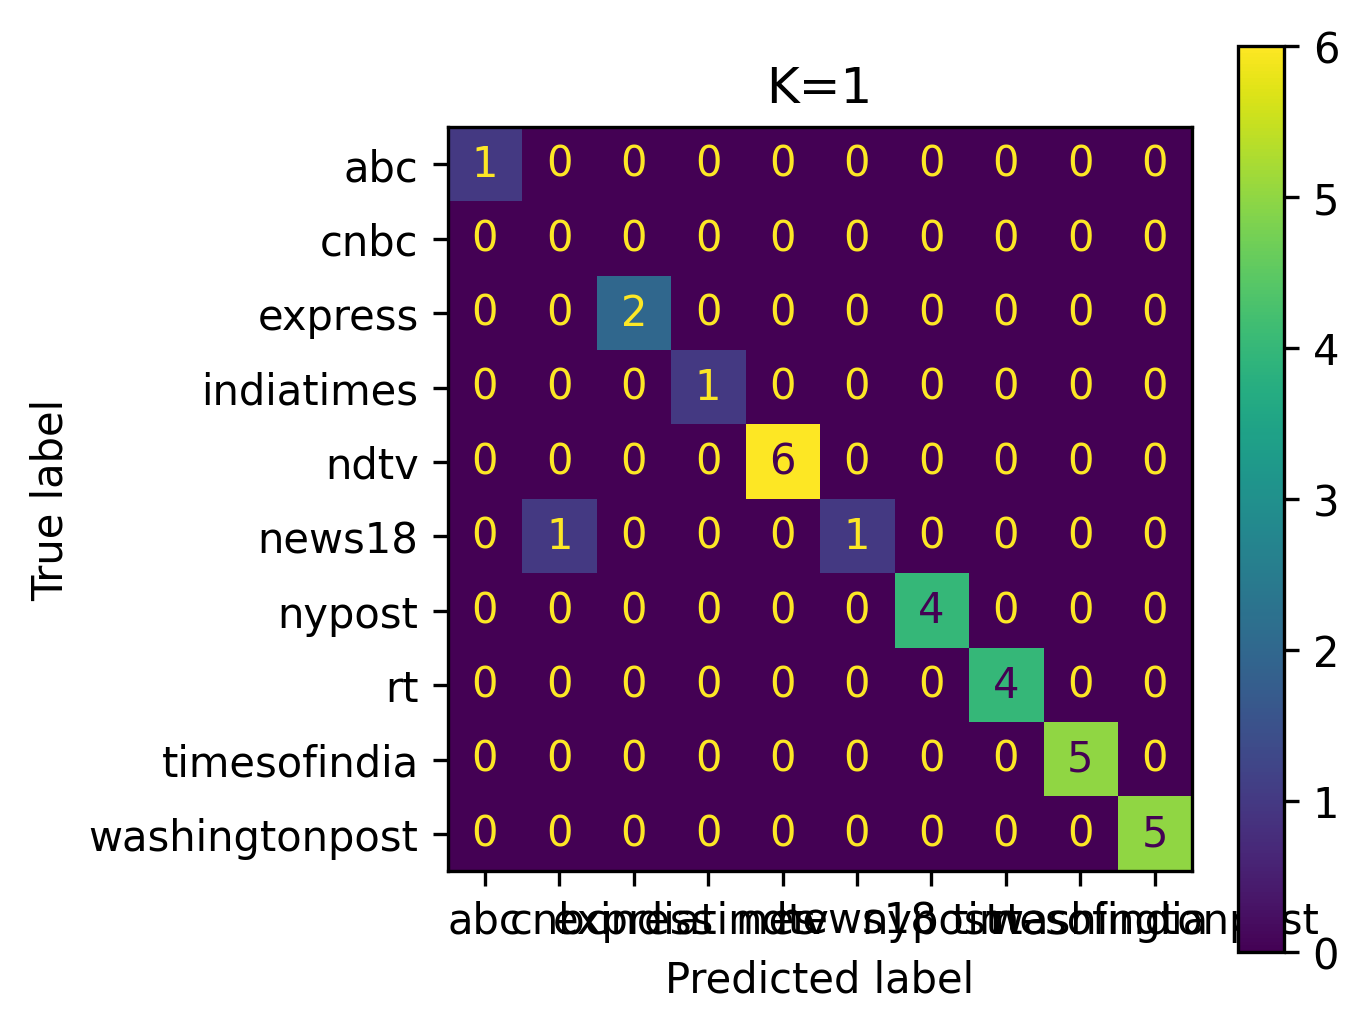

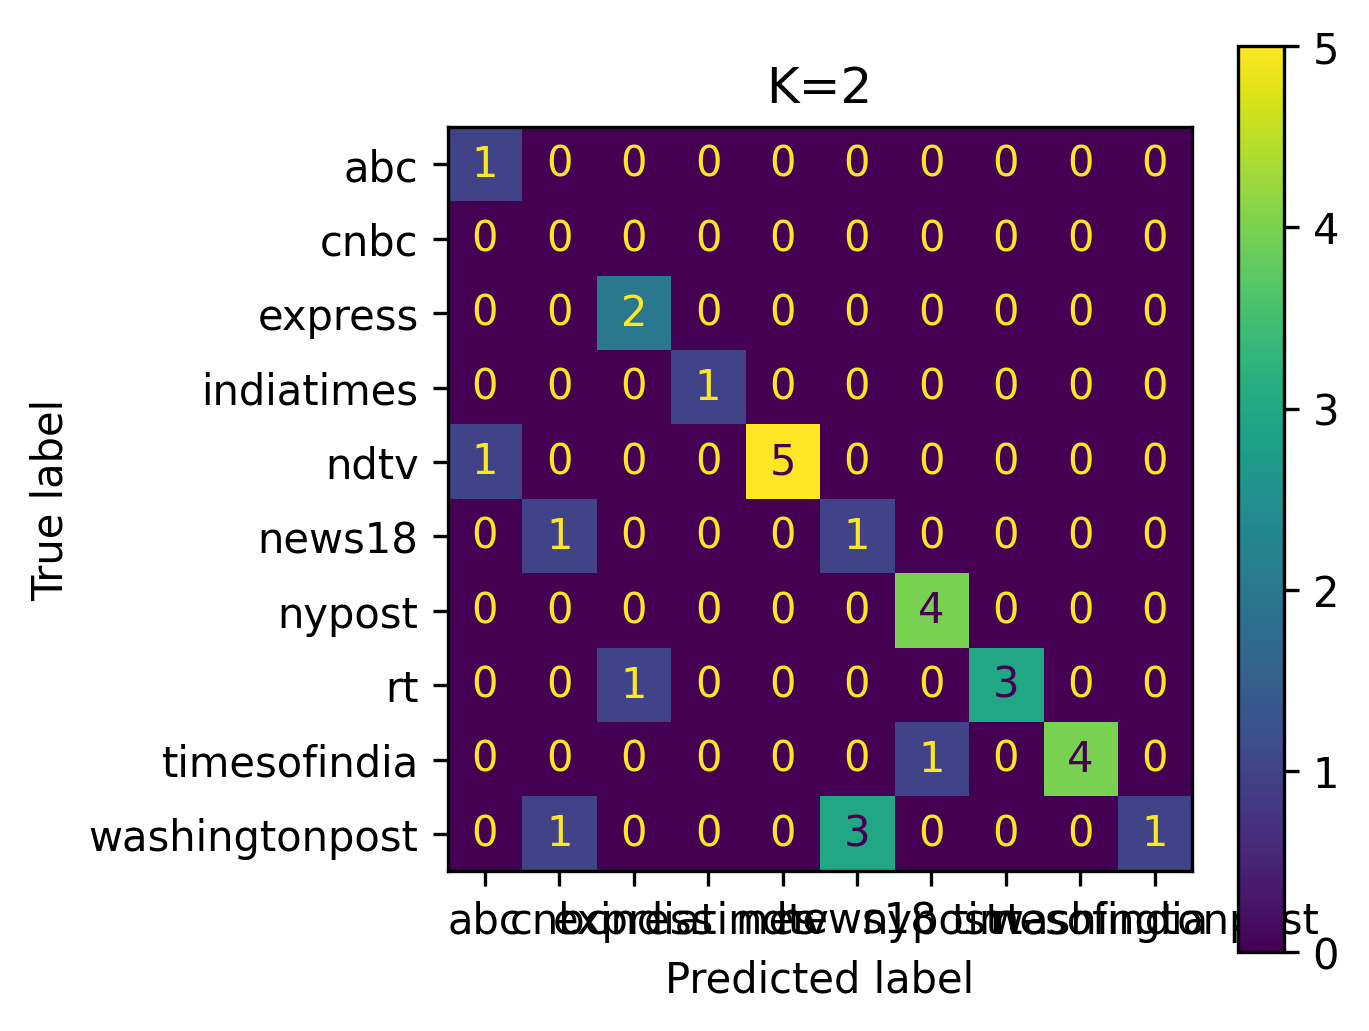

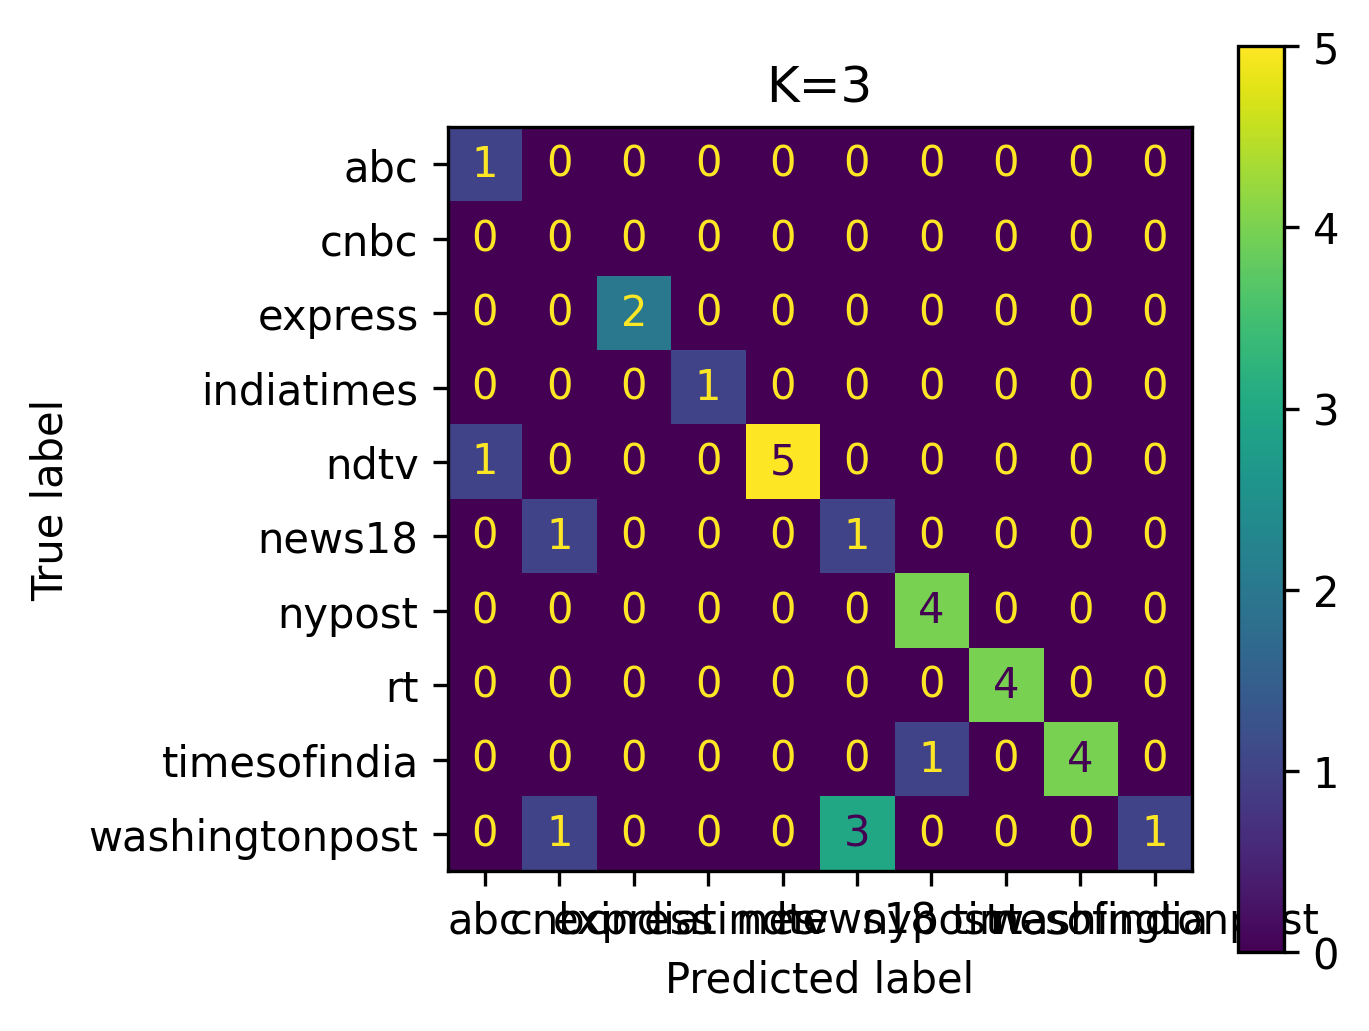

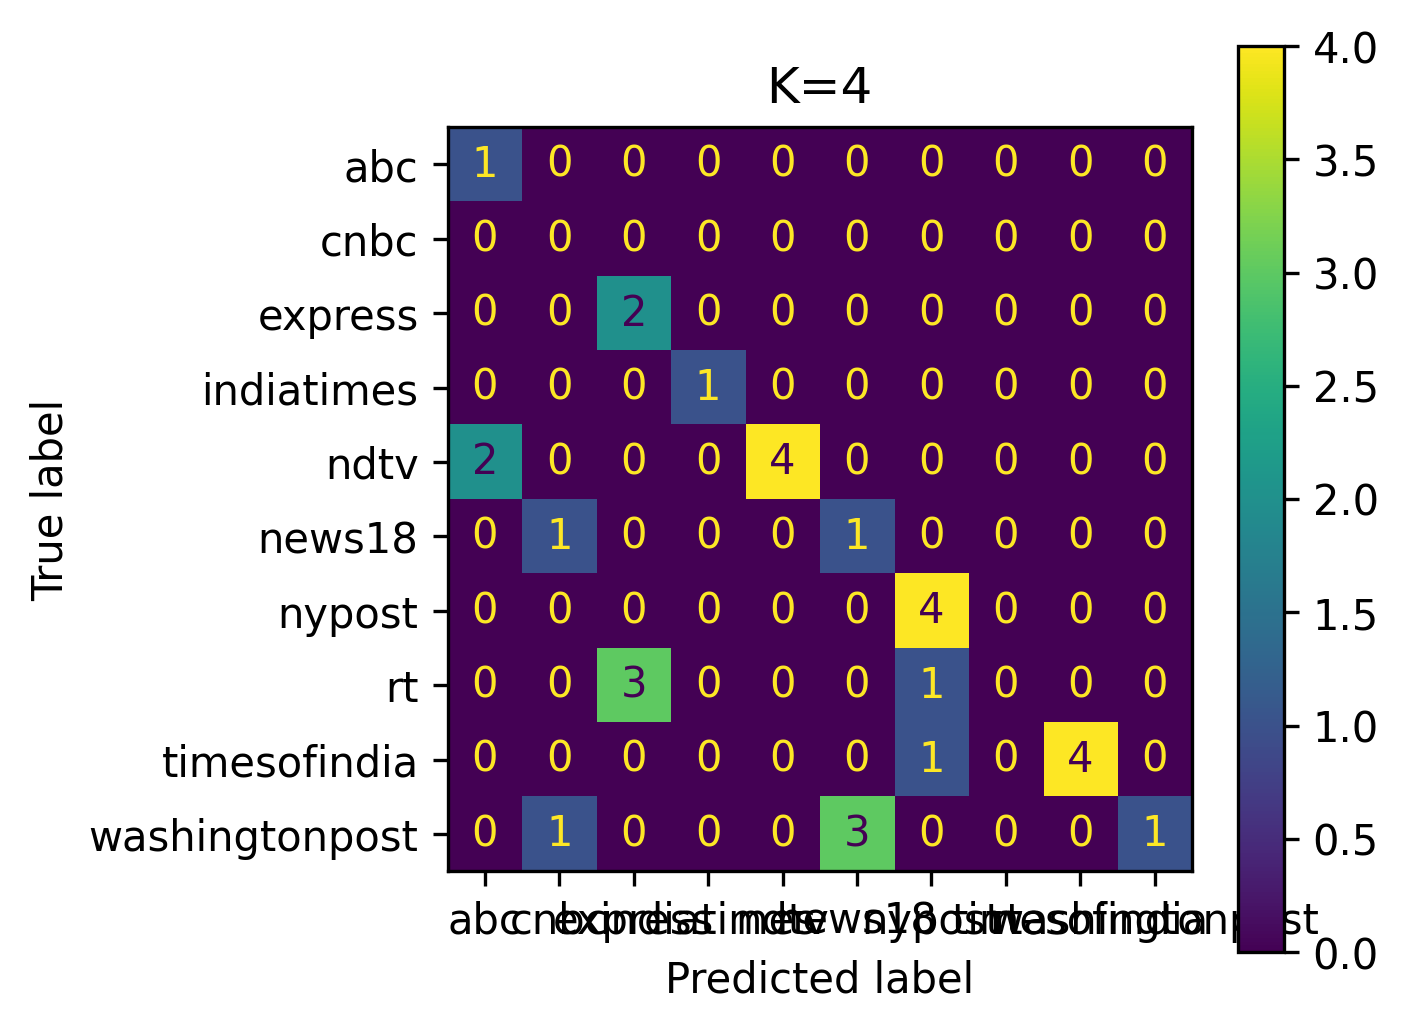

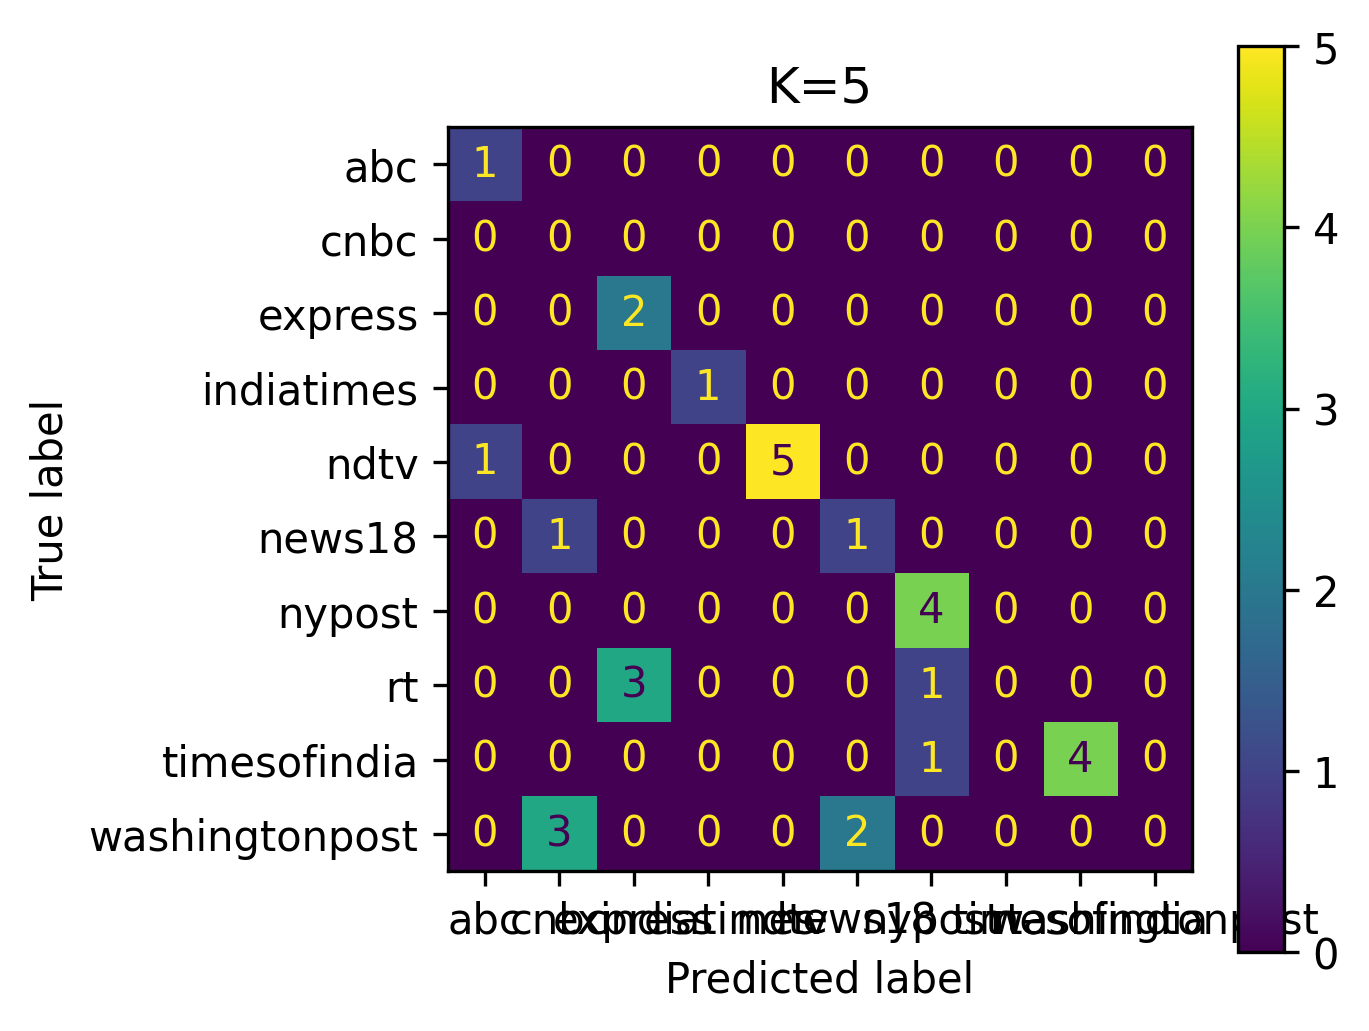

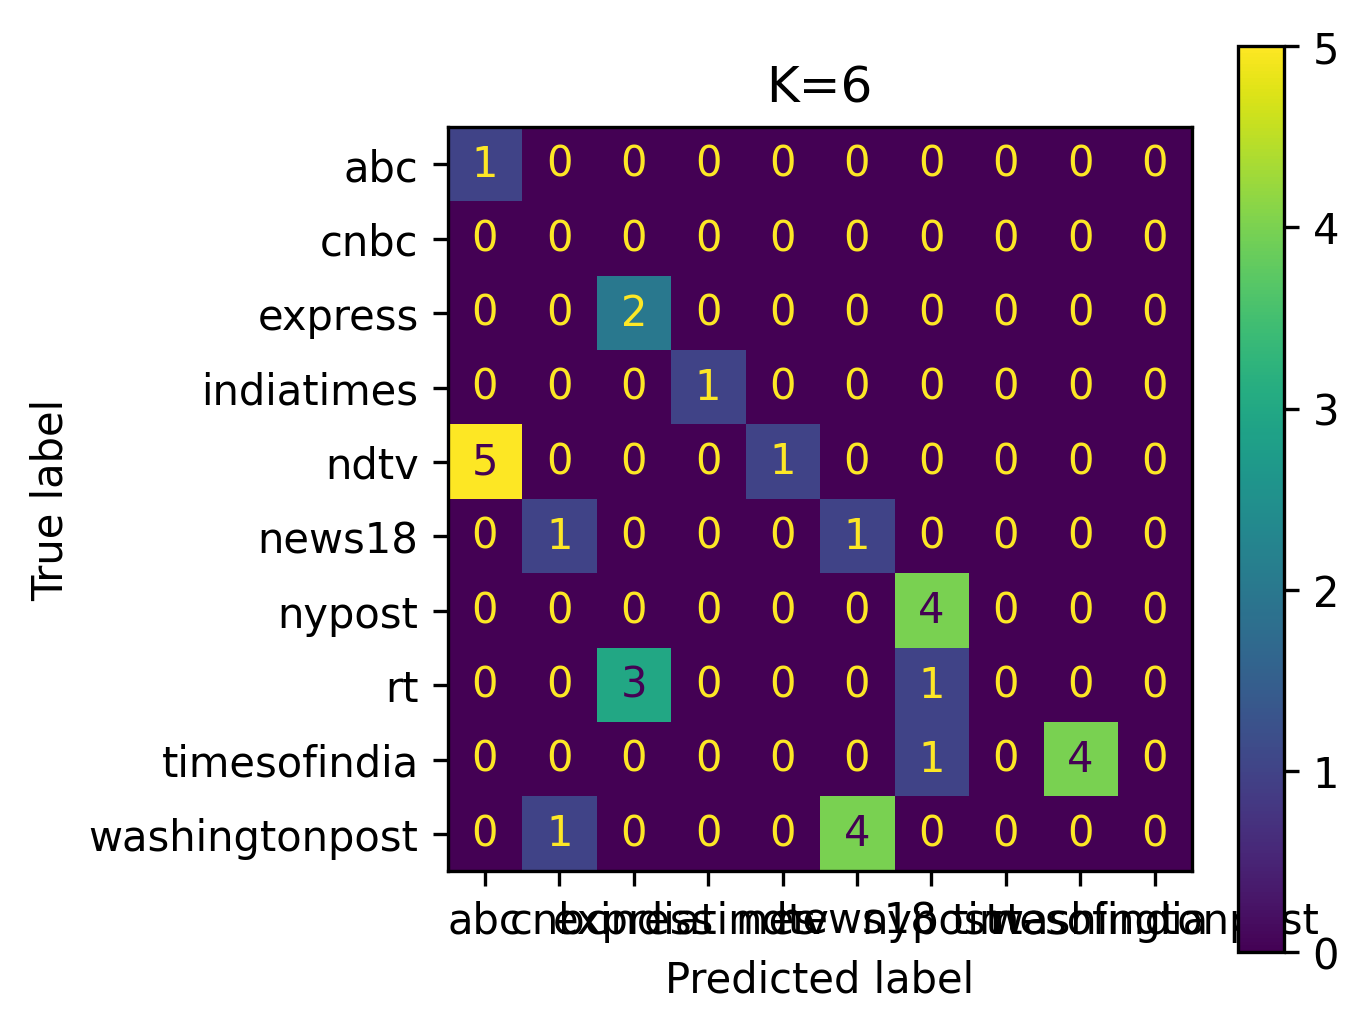

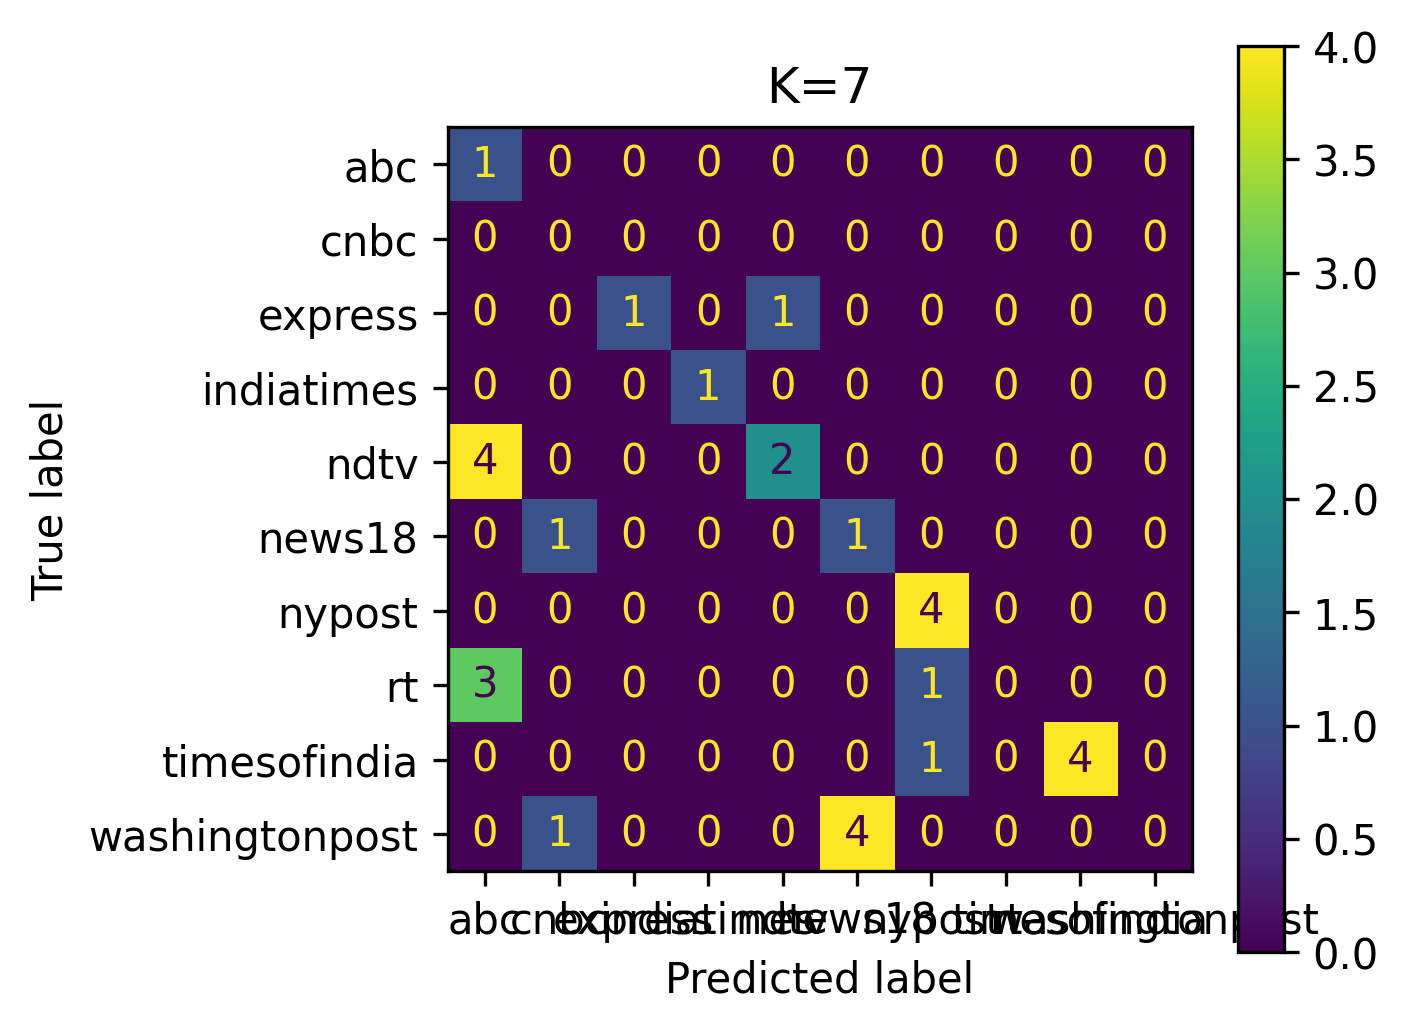

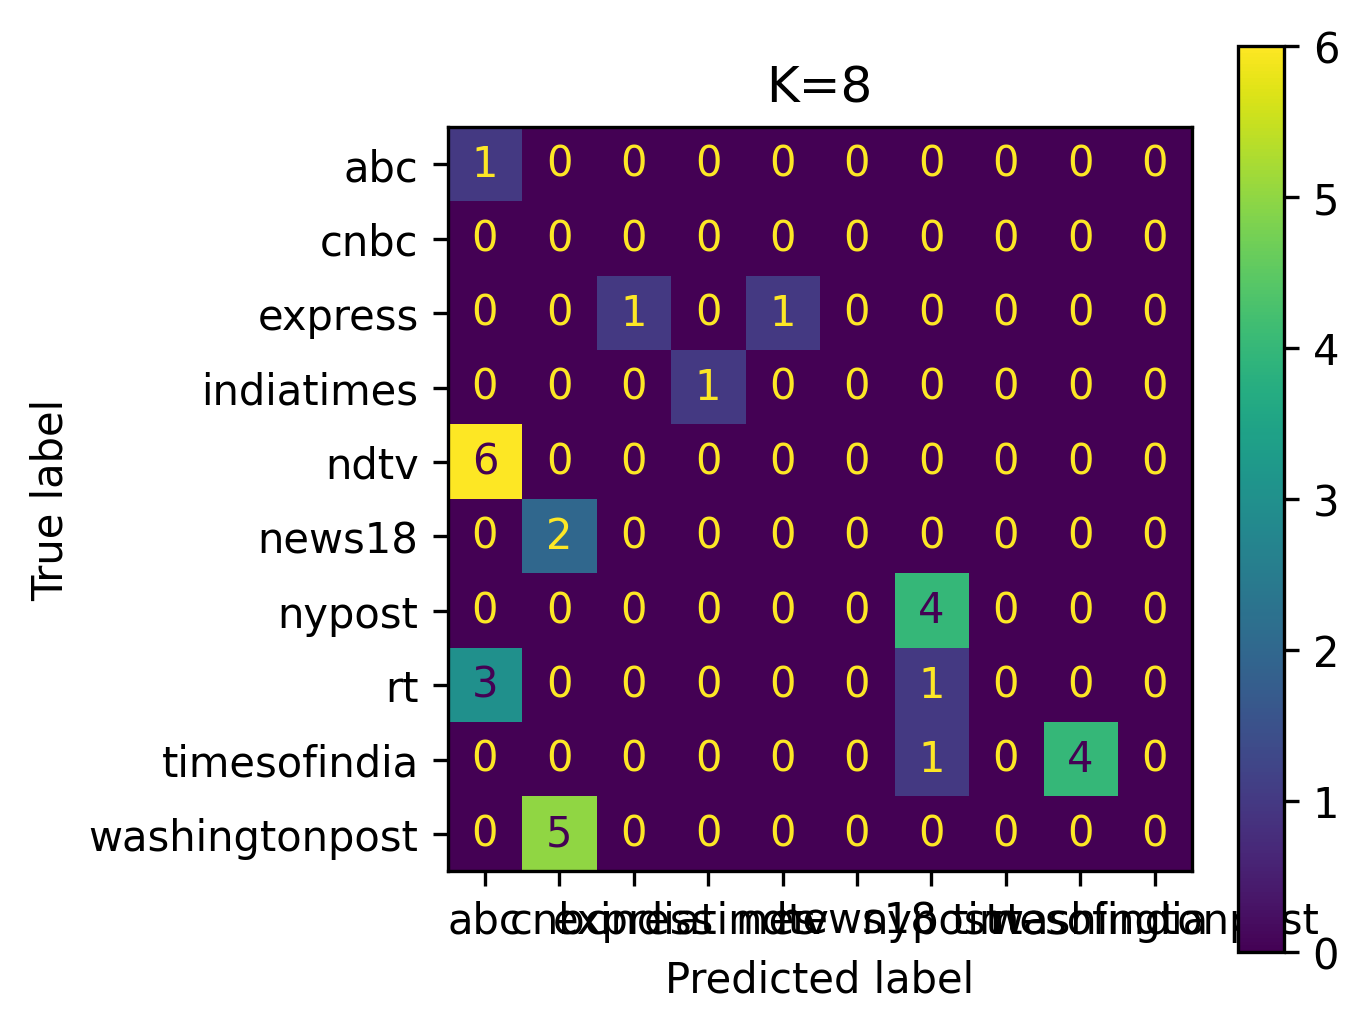

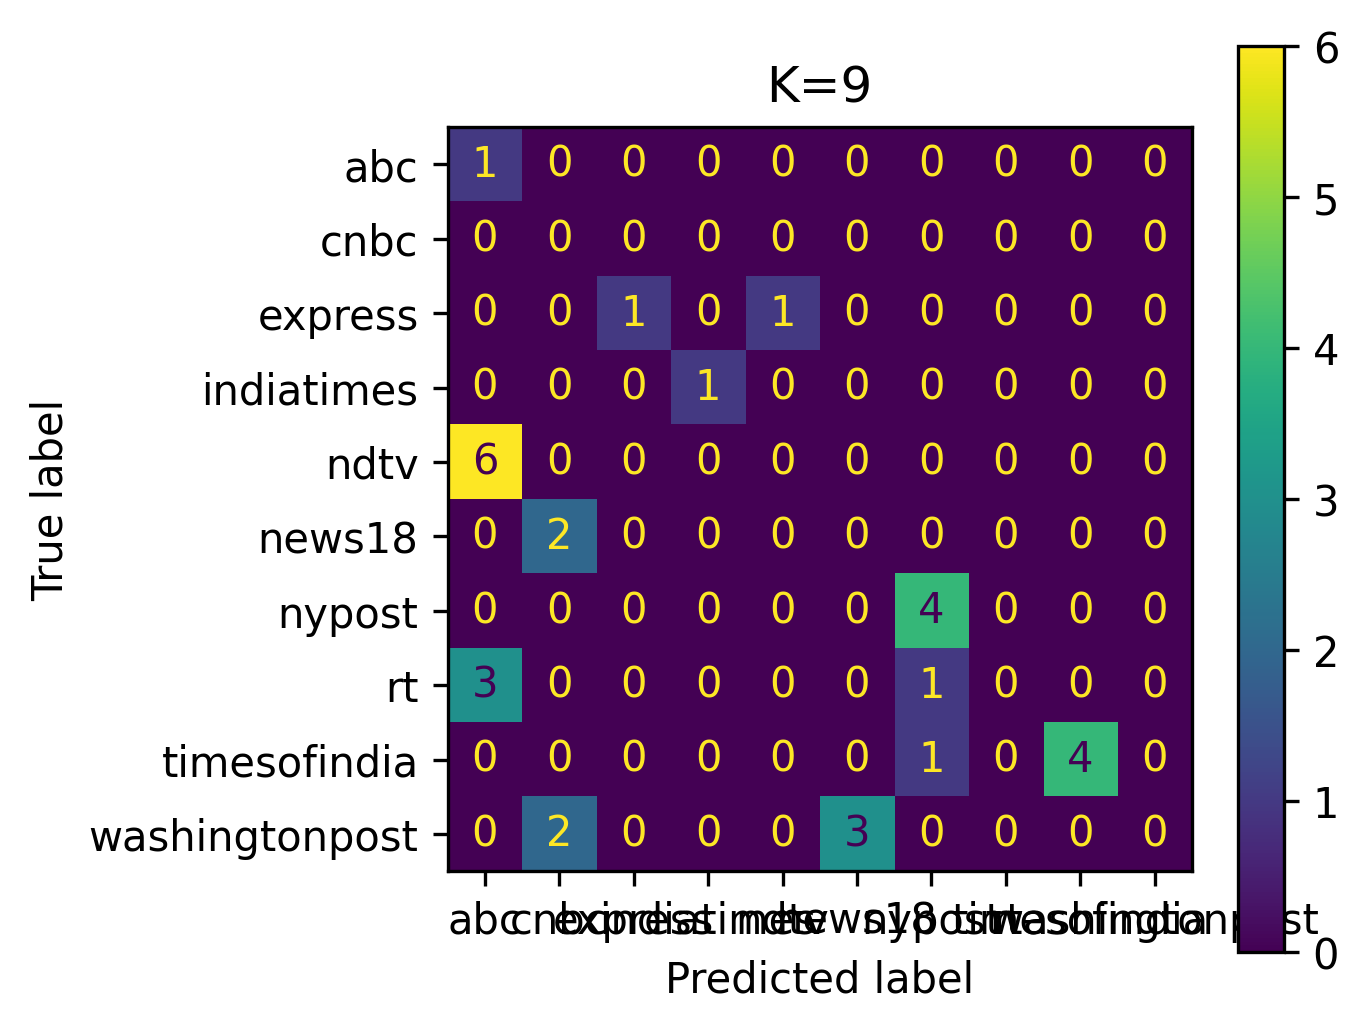

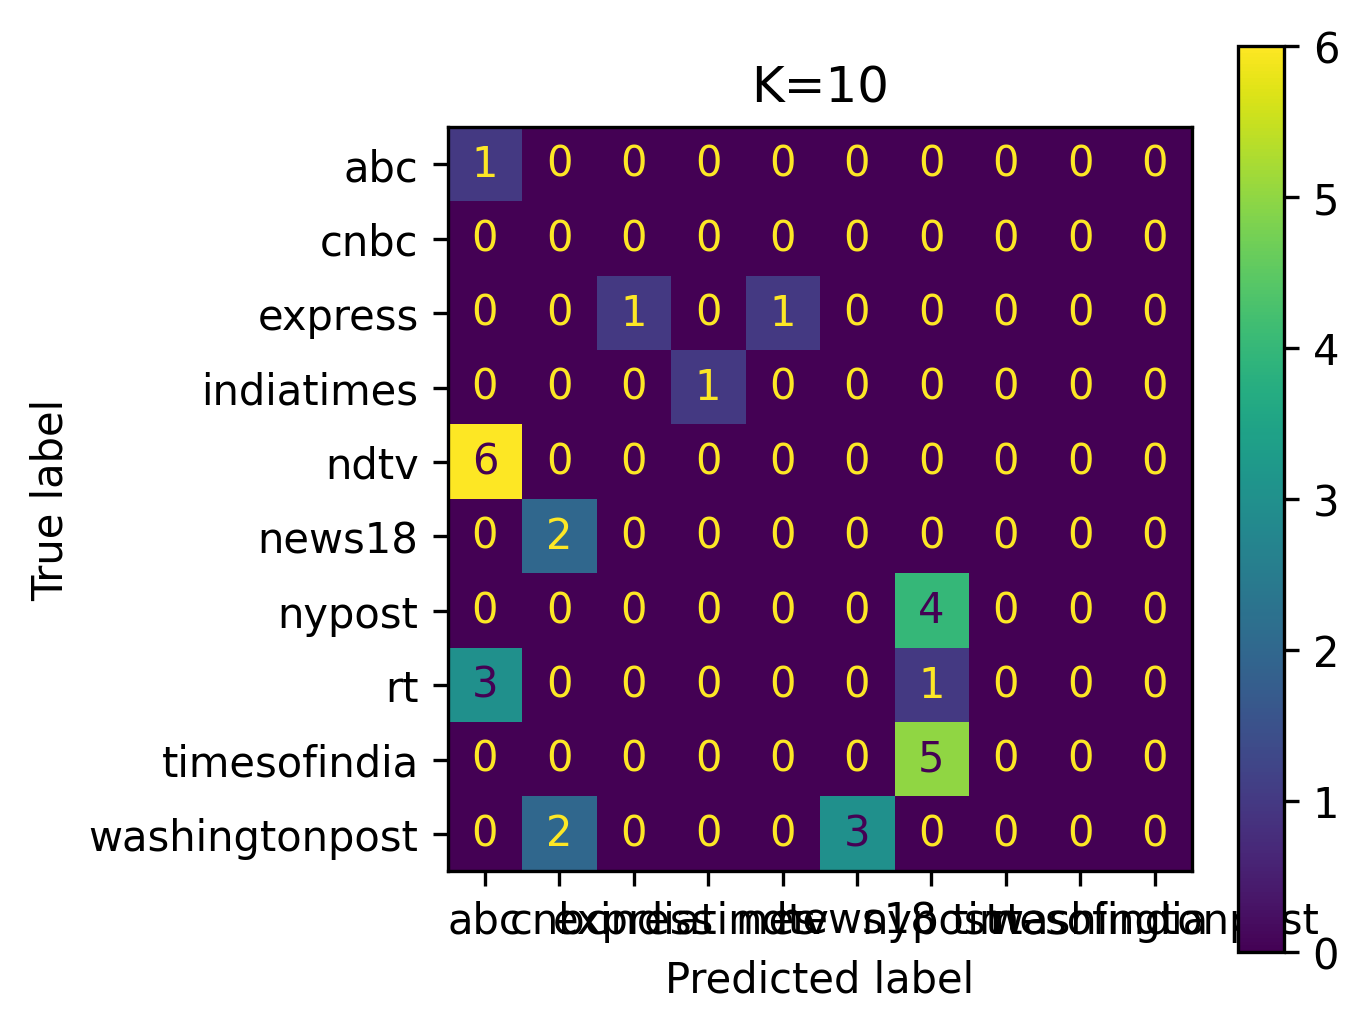

In [ ]:
#to reproduce the results
np.random.seed(1)

Y_fing_old = result_df3['label']
X_fing_old = result_df3.drop(['label'],axis=1)

X_norm_train_fing_old, X_norm_test_fing_old, Y_train_fing_old, Y_test_fing_old = Stand_Scaler_split(X_fing_old,Y_fing_old)

# problems when '0' was scalaeled
X_norm_train_fing_old['M0'] = 0
X_norm_test_fing_old['M0'] = 0

#train on old, test on old
A_fing_old = KNN(X_norm_train_fing_old, X_norm_test_fing_old, Y_train_fing_old, Y_test_fing_old)

We see that in general, the classifier performed better on statistical features wrt the newly obtained features for the old data. However, will it be the case when the test data is less correlated to the training data. Let's train the model on the same data, but obtain the perforance on the data captured a week later.

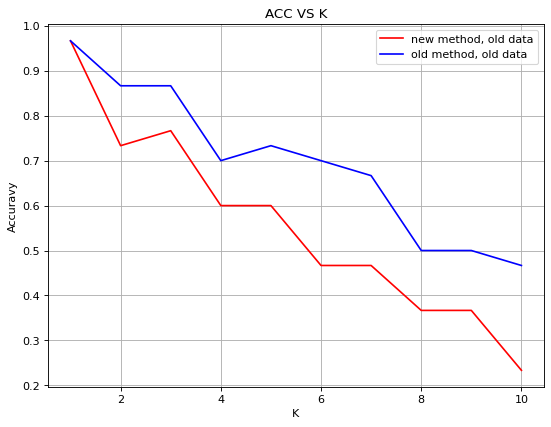

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(range(1,11)),A_fing_old, 'r') 
plt.plot(list(range(1,11)),A_old, 'b') 

plt.xlabel("K")
plt.ylabel("Accuravy")
plt.grid(visible=True);
plt.title('ACC VS K')
plt.legend(['new method, old data', 'old method, old data'])
plt.show()

Generate another dataset with features from the paper based on the new data.

In [ ]:
result_df4 = dataset_generator_fingerprinting(M, data_new)# new data
display(result_df4)

label   M0           M1           M2            M3            M4  \
0         cnbc  0.0  2794.000000  3096.142857  14740.714286  29795.285714   
1         cnbc  0.0  2568.476190  8013.238095  27202.857143  54804.000000   
2         cnbc  0.0  2674.809524  4445.238095  18334.857143  37940.476190   
3         cnbc  0.0  2756.666667  3180.809524  17702.714286  33744.619048   
4         cnbc  0.0  2718.619048  3459.285714  18343.714286  36820.952381   
..         ...  ...          ...          ...           ...           ...   
94  indiatimes  0.0   -74.000000  -657.000000   2305.000000   3571.000000   
95  indiatimes  0.0   -70.476190  -601.476190   1881.857143   3329.857143   
96  indiatimes  0.0   -74.000000  -657.000000   2305.000000   3571.000000   
97  indiatimes  0.0   -74.000000  -657.000000   2305.000000   3571.000000   
98  indiatimes  0.0   -66.952381  -545.952381   1458.714286   3088.714286   

              M5             M6             M7             M8  ...  \
0   43608.714286   62593.571429   93783.000000  130143.857143  ...   
1   81164.000000  114764.000000  165740.000000  262638.285714  ...   
2   63613.904762   96596.285714  135370.666667  174007.142857  ...   
3   51234.523810   75757.571429  115174.333333  151419.285714  ...   
4   55849.809524   95909.142857  140519.333333  202574.476190  ...   
..           ...            ...            ...            ...  ...   
94   5085.000000    5217.000000    5025.000000    5142.000000  ...   
95   4724.523810    5179.285714    5089.000000    5097.428571  ...   
96   5085.000000    5217.000000    5025.000000    5142.000000  ...   
97   5085.000000    5217.000000    5025.000000    5142.000000  ...   
98   4364.047619    5141.571429    5153.000000    5052.857143  ...   

              M11            M12            M13           M14           M15  \
0   324658.428571  447692.428571  529913.000000  6.457070e+05  8.336941e+05   
1   600096.190476  819522.857143  916864.047619  9.847733e+05  1.034152e+06   
2   477467.047619  669108.857143  867783.809524  1.007711e+06  1.183850e+06   
3   404471.476190  531319.857143  727810.142857  9.003050e+05  9.991587e+05   
4   457222.476190  632083.714286  836456.571429  9.806340e+05  1.189971e+06   
..            ...            ...            ...           ...           ...   
94    4793.000000    4656.000000    4790.000000  4.894000e+03  5.483000e+03   
95    4849.571429    4734.285714    4707.047619  4.824667e+03  5.062286e+03   
96    4793.000000    4656.000000    4790.000000  4.894000e+03  4.790000e+03   
97    4793.000000    4656.000000    4790.000000  4.686000e+03  4.790000e+03   
98    4906.809524    4808.428571    4688.619048  4.745333e+03  4.849429e+03   

             M16           M17           M18           M19           M20  
0   9.647956e+05  1.136027e+06  1.306225e+06  1.479318e+06  1.641448e+06  
1   1.100668e+06  1.152027e+06  1.202188e+06  1.343678e+06  1.559691e+06  
2   1.223754e+06  1.263658e+06  1.291284e+06  1.366356e+06  1.601698e+06  
3   1.216128e+06  1.404852e+06  1.595344e+06  1.664485e+06  1.693236e+06  
4   1.351939e+06  1.380776e+06  1.422760e+06  1.490710e+06  1.625913e+06  
..           ...           ...           ...           ...           ...  
94  5.854000e+03  5.958000e+03  5.854000e+03  5.800000e+03  5.746000e+03  
95  5.571095e+03  5.872810e+03  5.942143e+03  5.847857e+03  5.796429e+03  
96  5.379000e+03  5.750000e+03  5.854000e+03  5.800000e+03  5.746000e+03  
97  5.379000e+03  5.749000e+03  5.853000e+03  5.799000e+03  5.745000e+03  
98  5.174476e+03  5.638429e+03  5.861286e+03  5.776714e+03  5.727857e+03  

[99 rows x 22 columns]

We do the splitting as before and see the accuracy and the matrices. Personally, I believe the results are sufficiently good. Let's compare the cases.

Accuracy for K= 1 : 0.6666666666666666
Accuracy for K= 2 : 0.6
Accuracy for K= 3 : 0.7
Accuracy for K= 4 : 0.6
Accuracy for K= 5 : 0.6333333333333333
Accuracy for K= 6 : 0.6
Accuracy for K= 7 : 0.6
Accuracy for K= 8 : 0.6
Accuracy for K= 9 : 0.6
Accuracy for K= 10 : 0.5


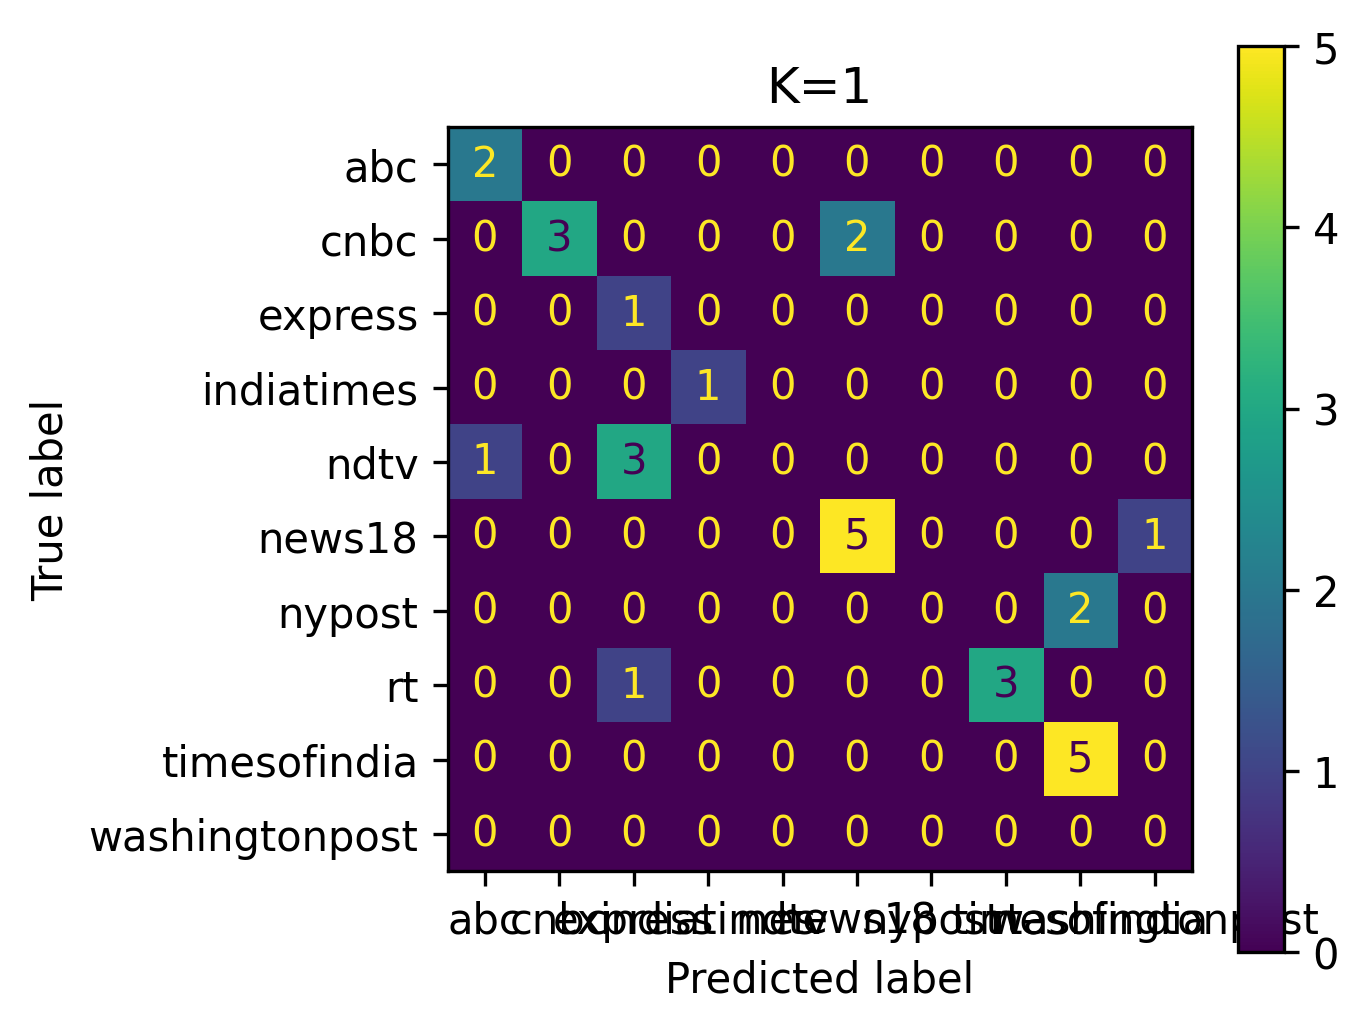

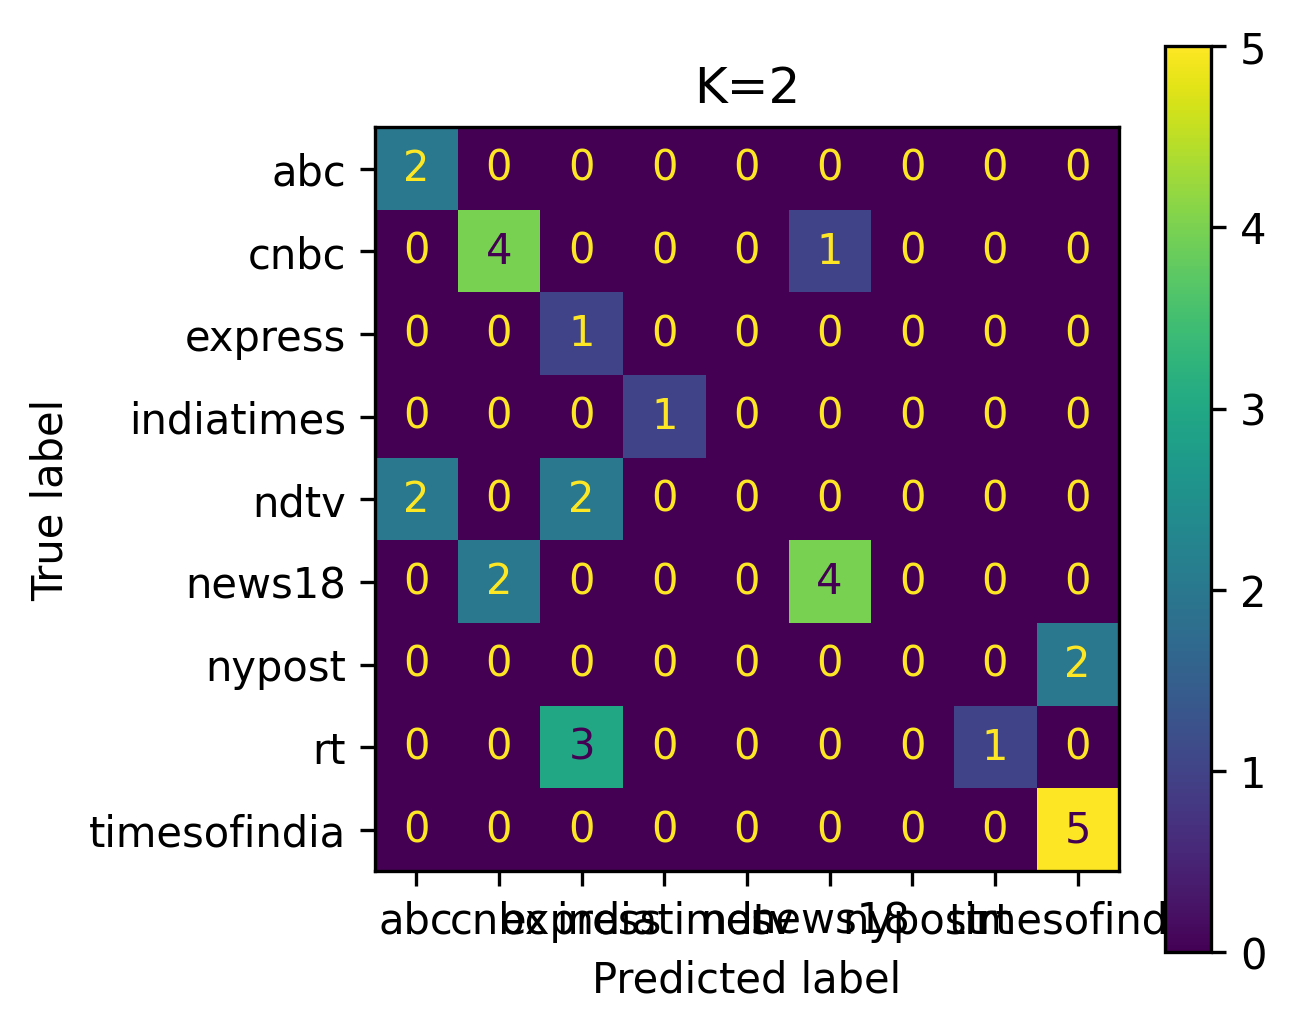

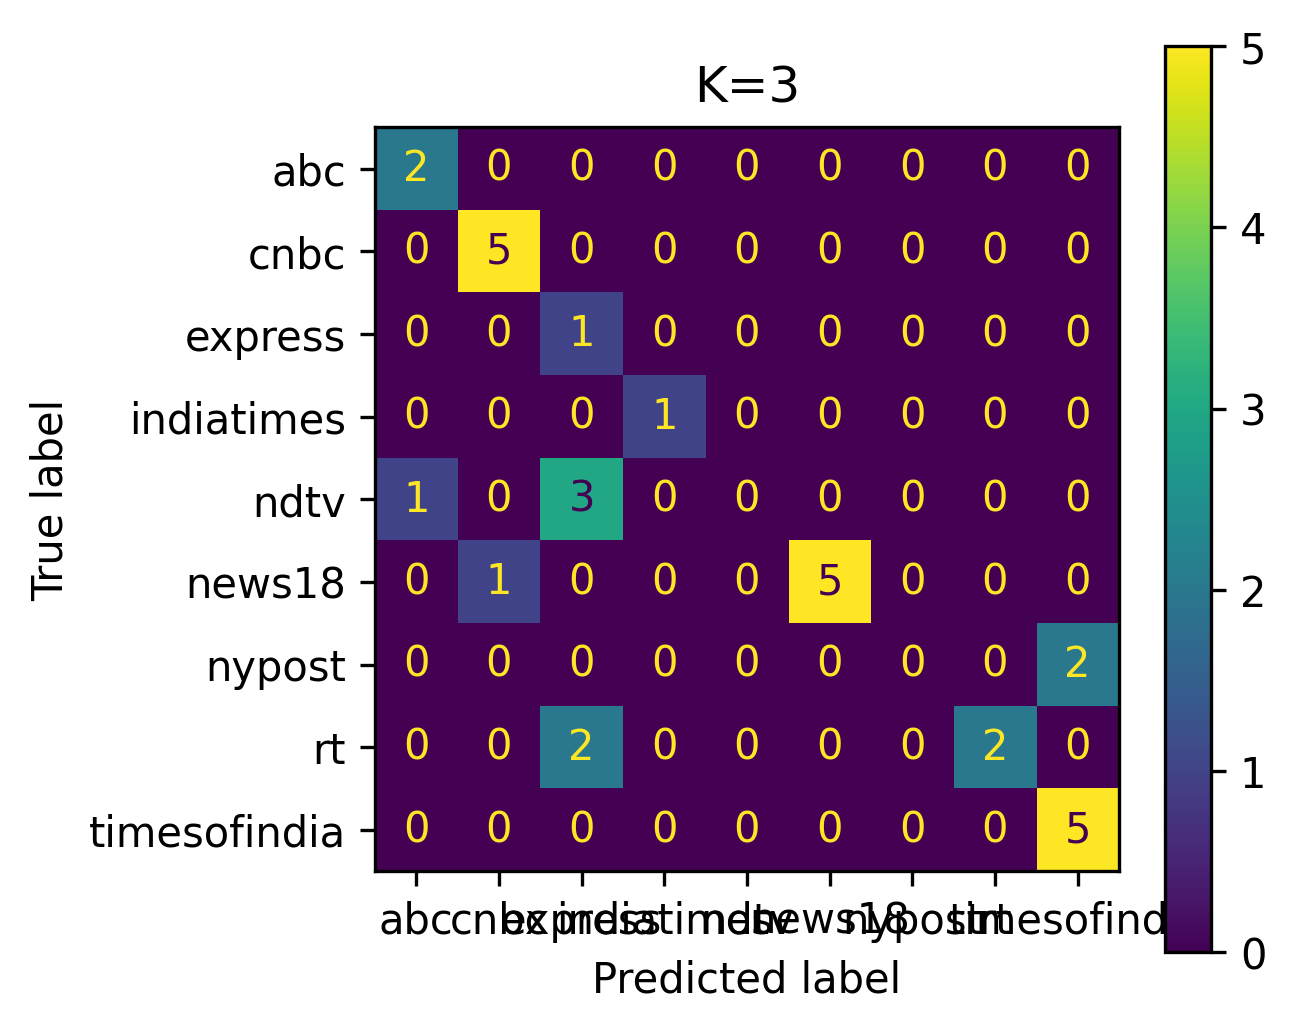

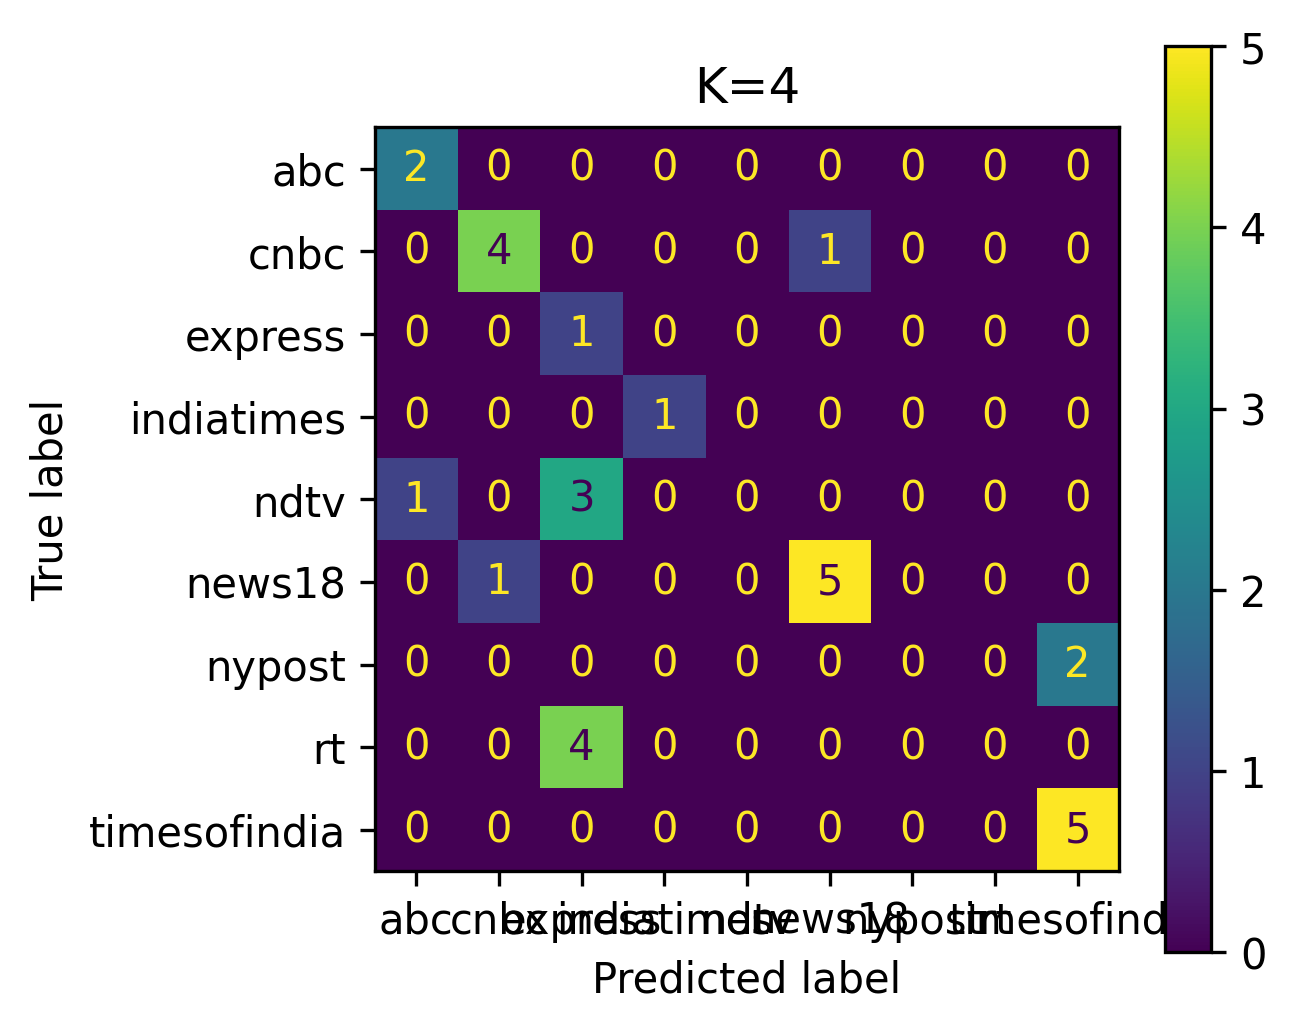

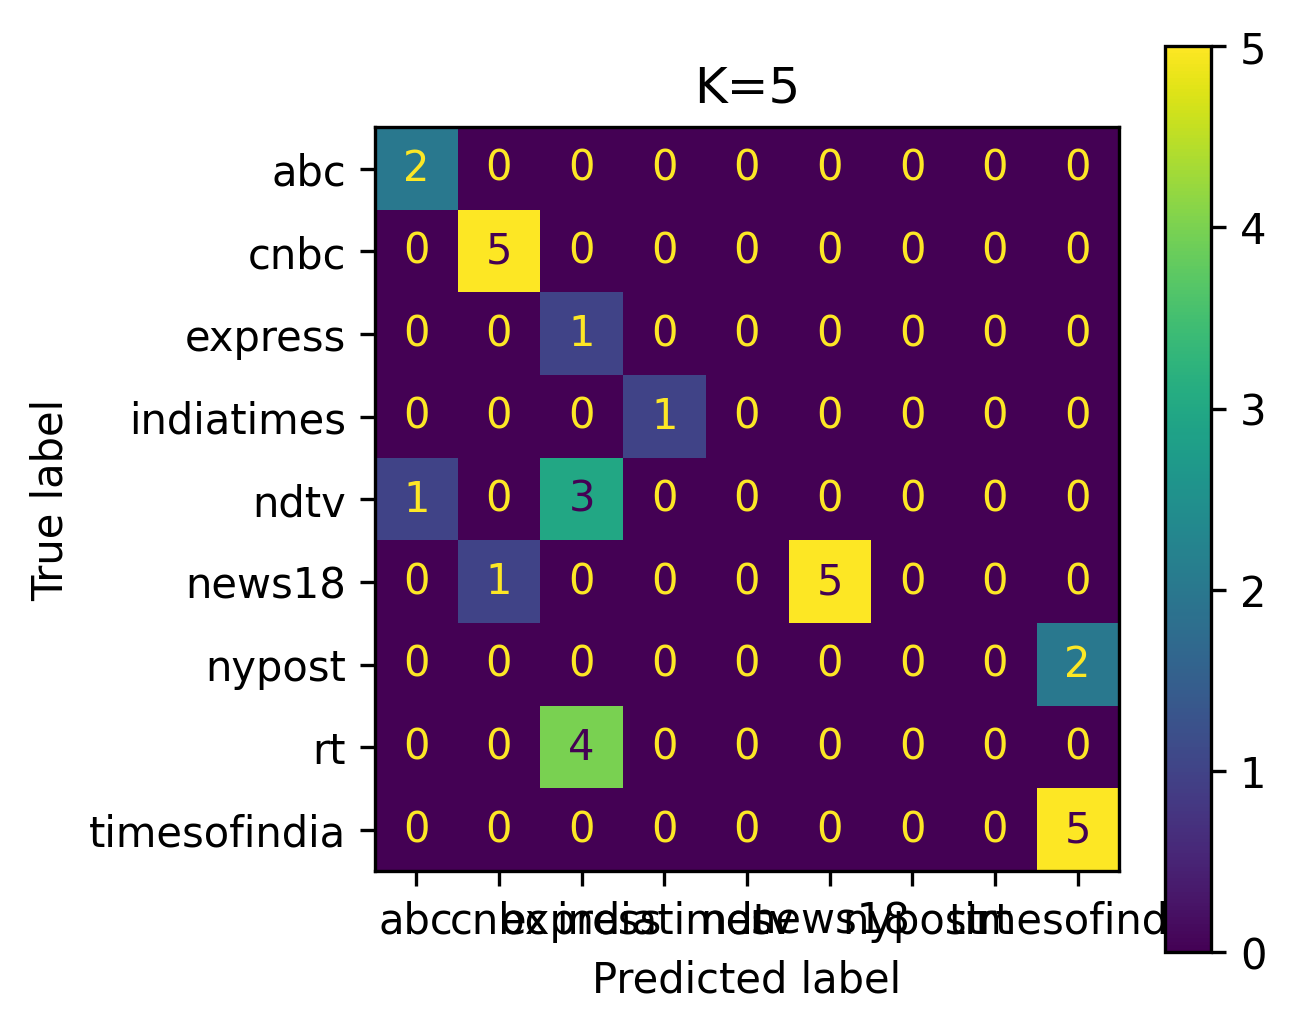

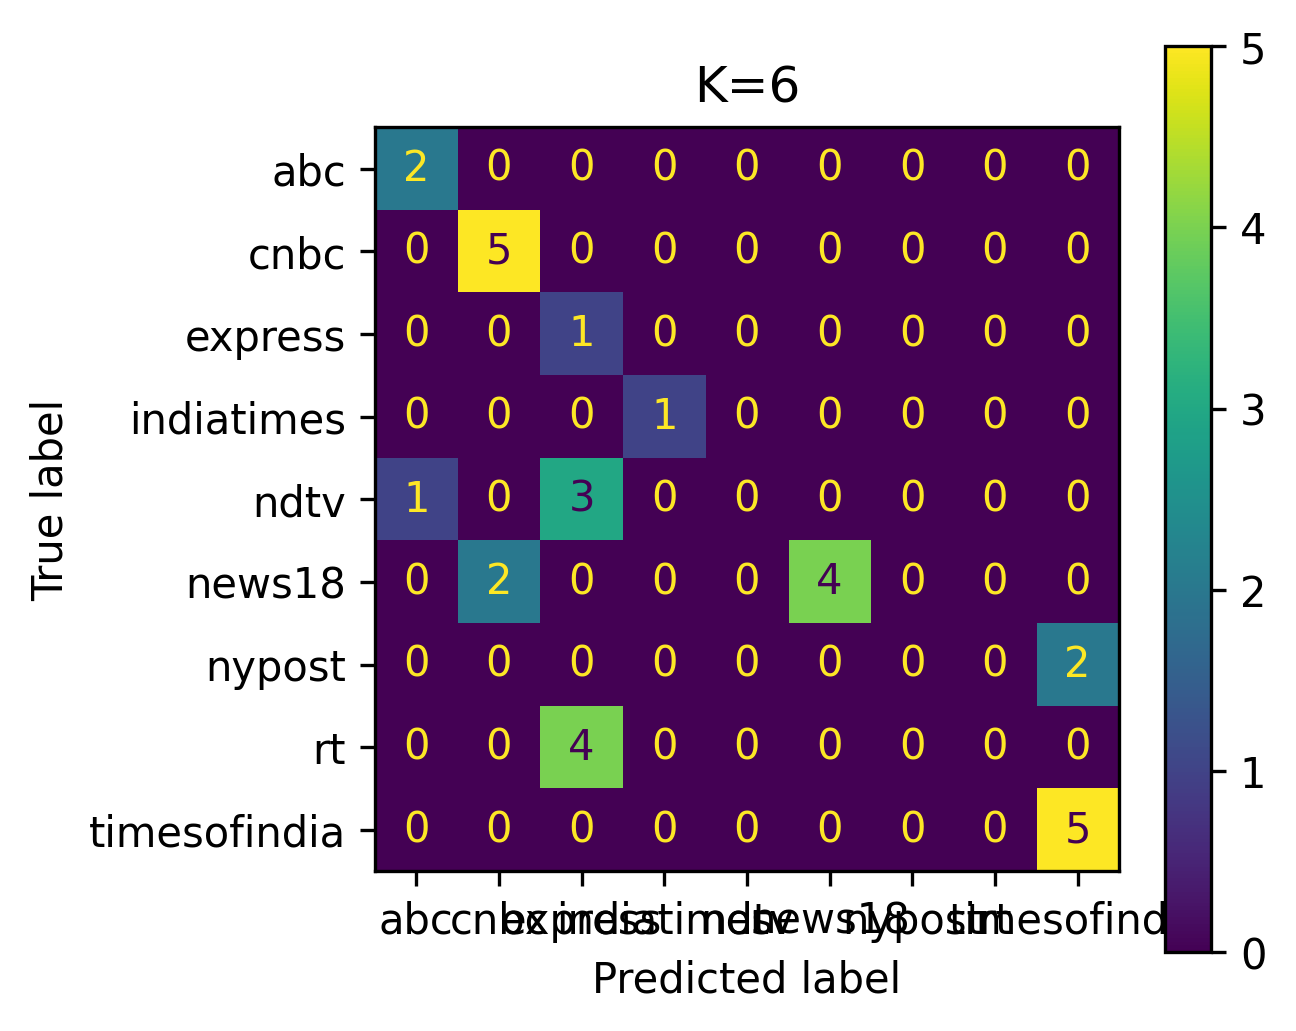

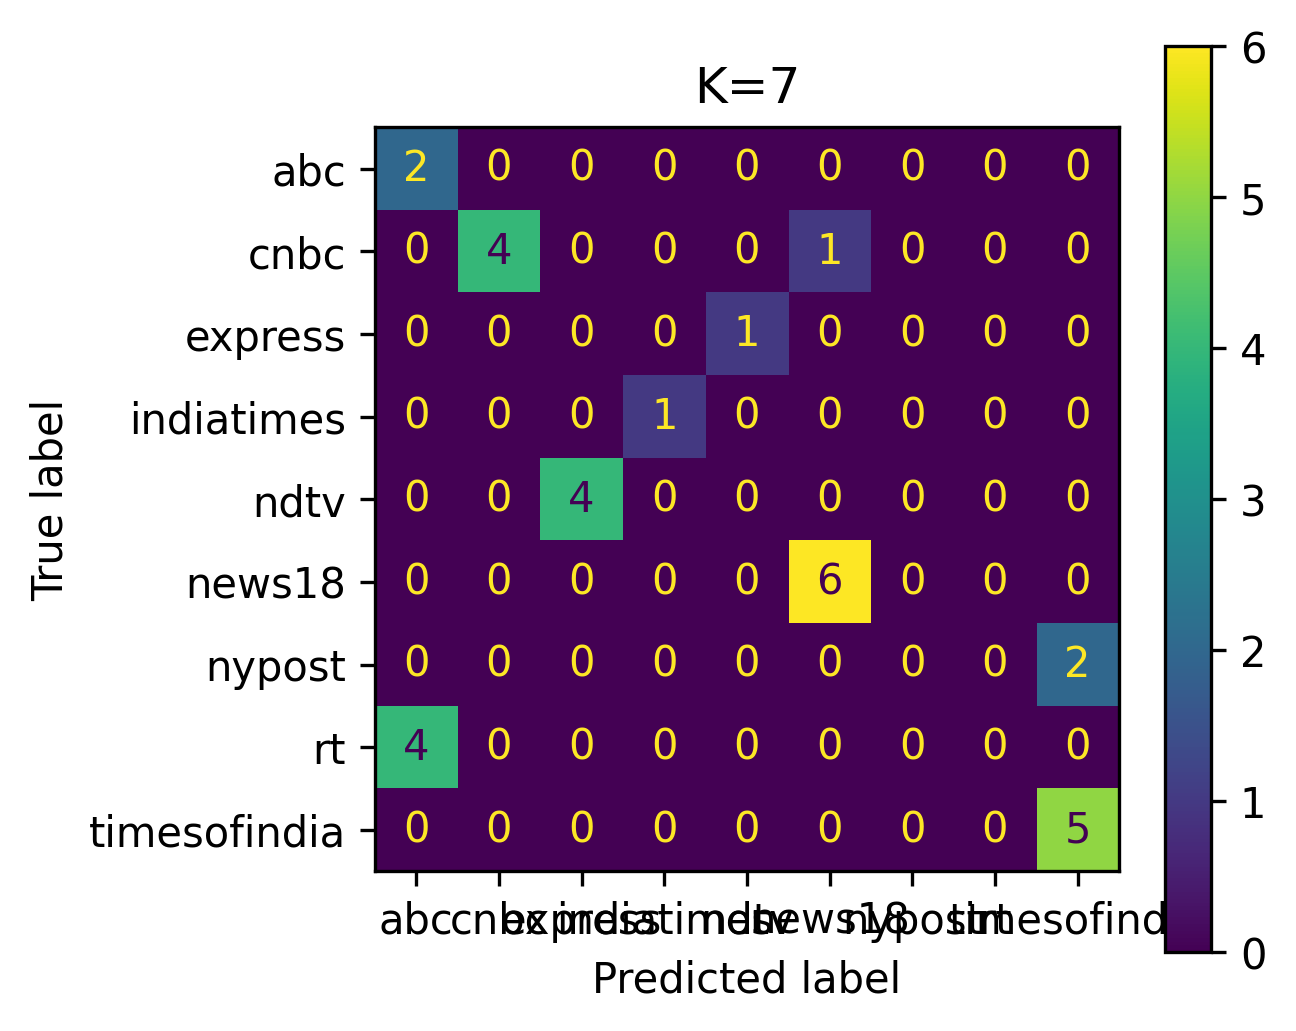

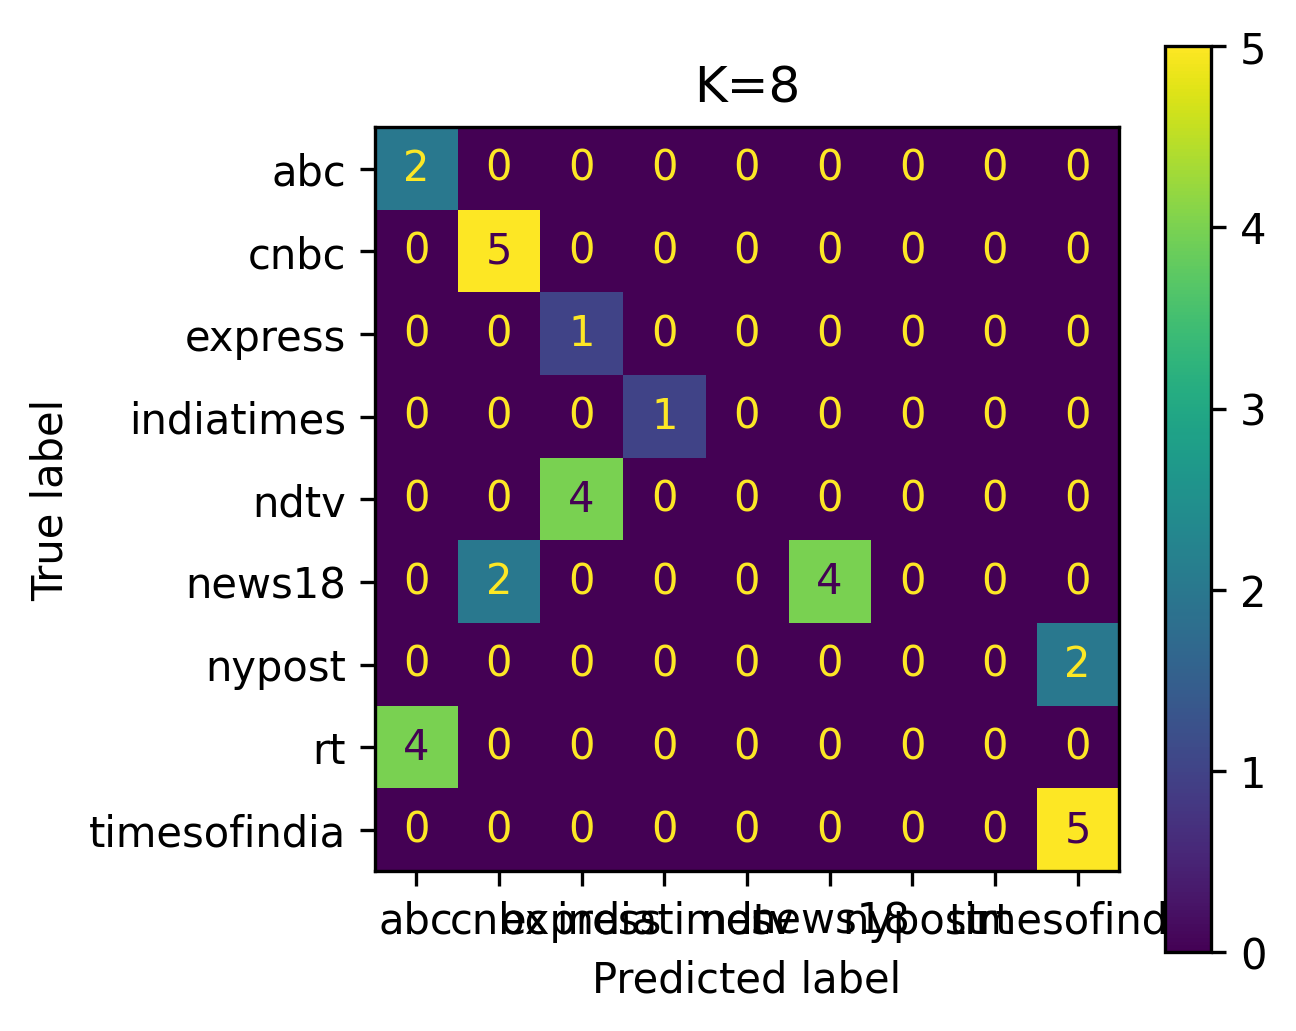

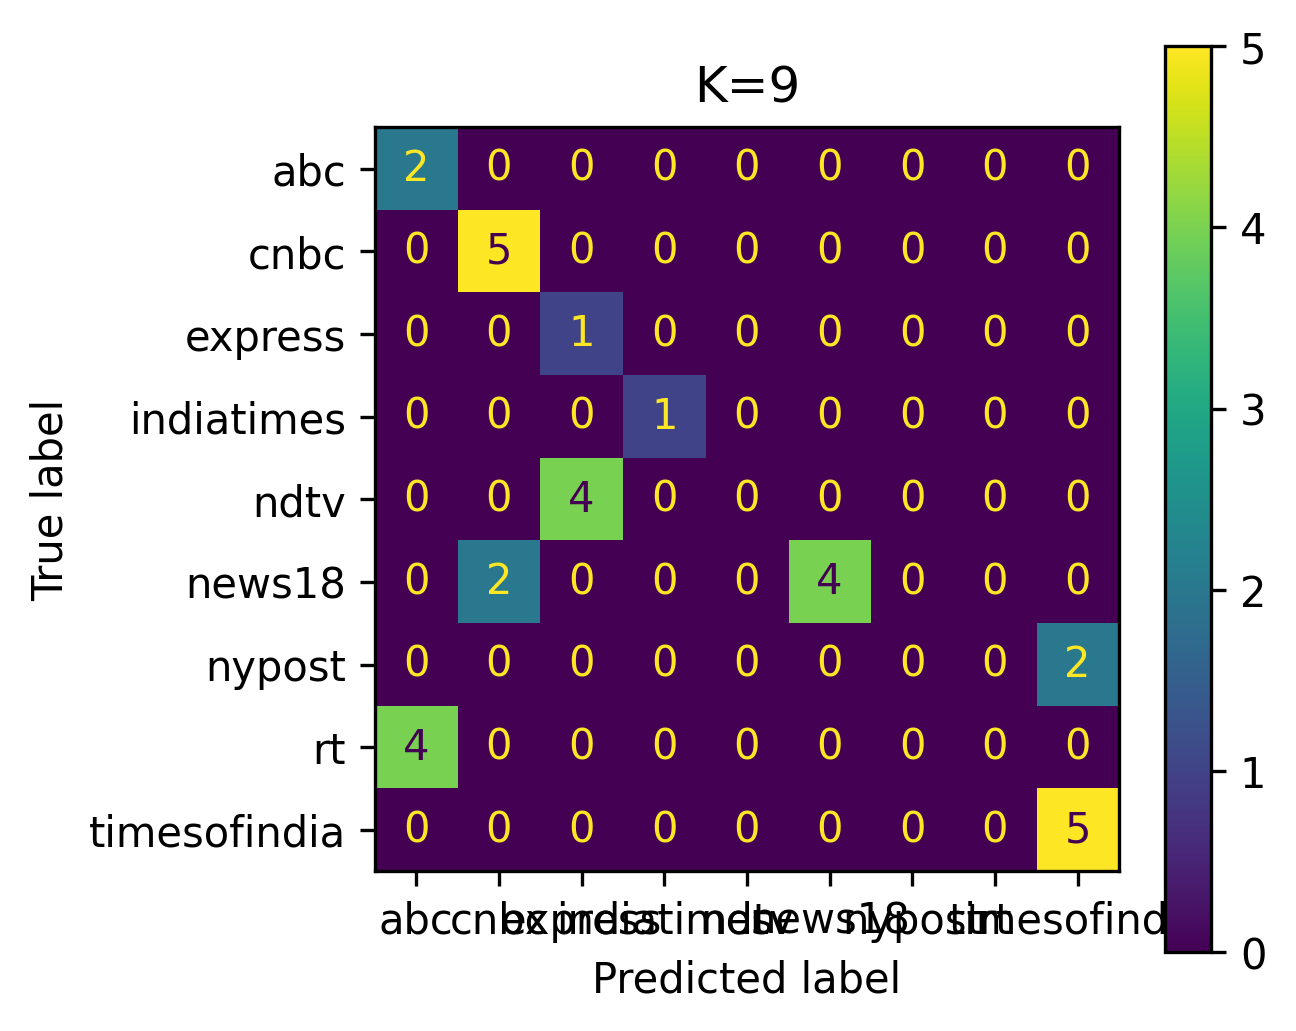

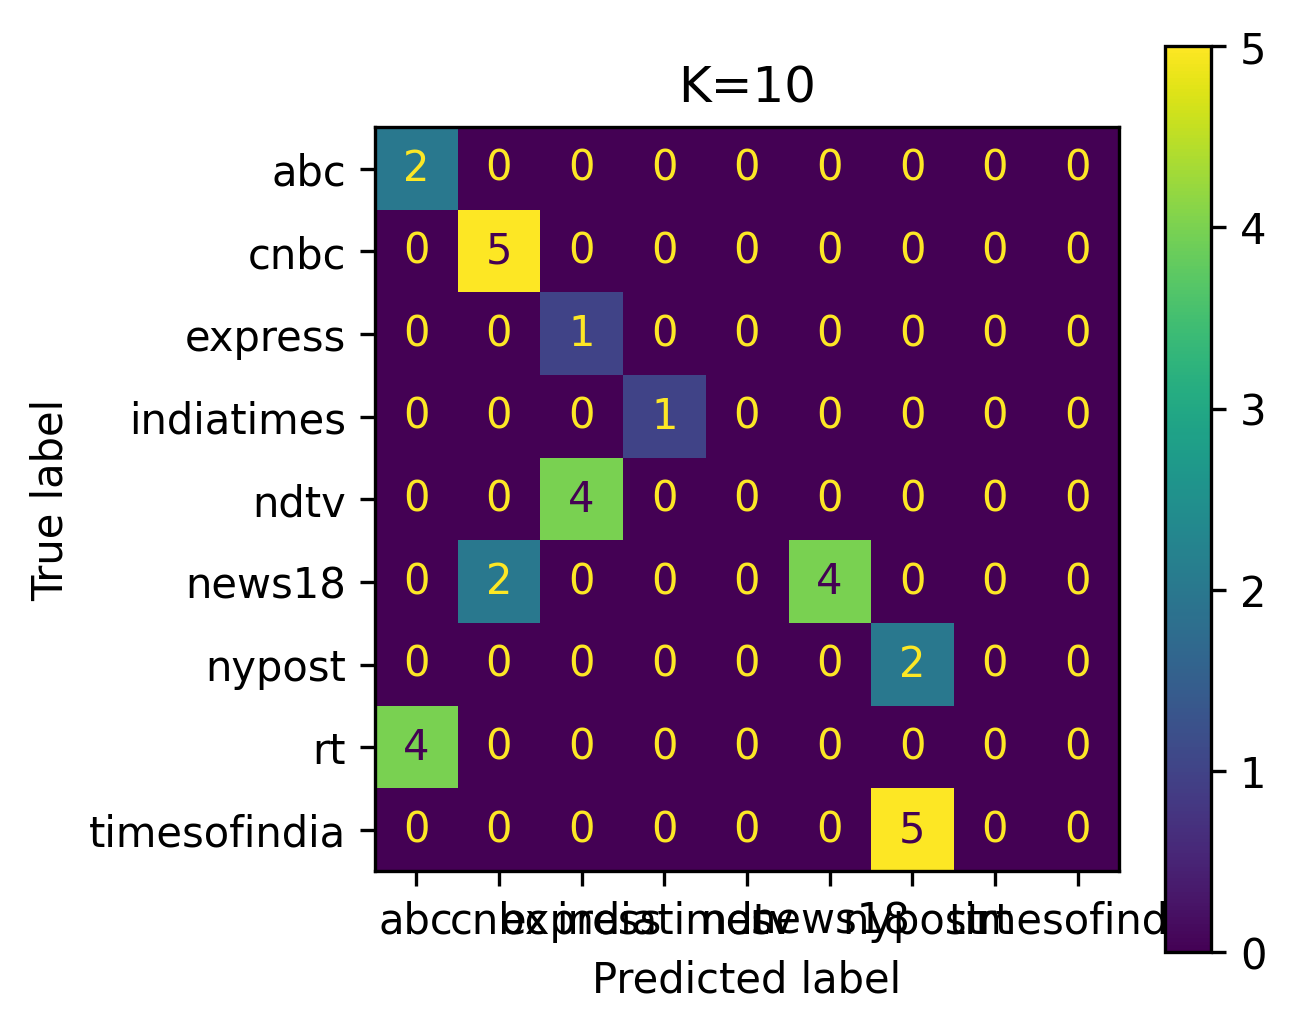

In [ ]:
np.random.seed(1)

Y_fing_new = result_df4['label']
X_fing_new = result_df4.drop(['label'],axis=1)

X_norm_train_fing_new, X_norm_test_fing_new, Y_train_fing_new, Y_test_fing_new = Stand_Scaler_split(X_fing_new,Y_fing_new)

# problems when '0' was scalaeled
X_norm_train_fing_new['M0'] = 0
X_norm_test_fing_new['M0'] = 0

#train on old, test on new
A_fing_new = KNN(X_norm_train_fing_old, X_norm_test_fing_new, Y_train_fing_old, Y_test_fing_new)

Comparison between the new method when the old data was used for testing and when the new data was used for validation (both are trained on the old data).


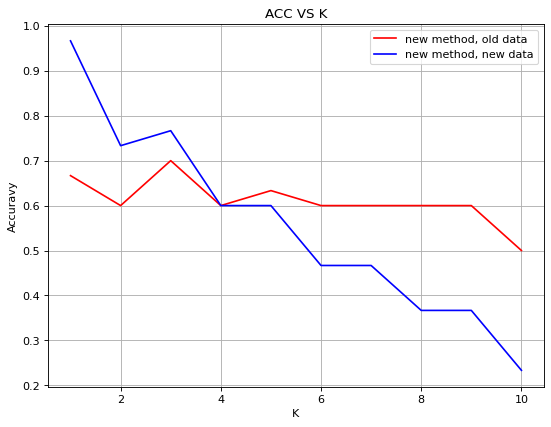

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(range(1,11)),A_fing_new, 'r') 
plt.plot(list(range(1,11)),A_fing_old, 'b') 

plt.xlabel("K")
plt.ylabel("Accuravy")
plt.grid(visible=True);
plt.title('ACC VS K')
plt.legend(['new method, old data', 'new method, new data'])
plt.show()

As we see, the new features has a better result than the statistical features when the traffic is captured a week later. On top of that, again, a suggested number of 'K' would be 3, and would give a better accuracy by around 10% wrt statistical features.

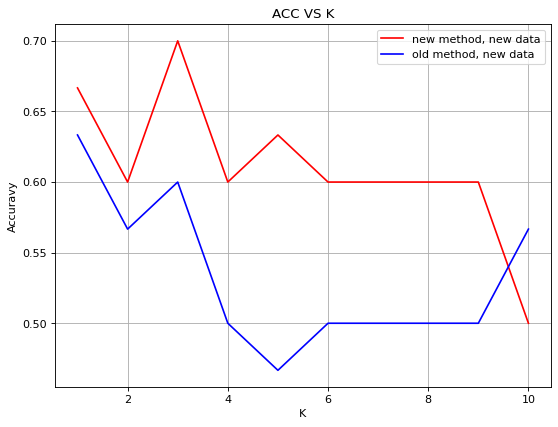

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(range(1,11)),A_fing_new, 'r') 
plt.plot(list(range(1,11)),A_new, 'b') 

plt.xlabel("K")
plt.ylabel("Accuravy")
plt.grid(visible=True);
plt.title('ACC VS K')
plt.legend(['new method, new data', 'old method, new data'])
plt.show()

This is just an example of how some cells could be simplified using prebuild functions for normalization, splitting and classification.

In [ ]:
#SKLEARN METHOD (NOT USED, JUST LISTED AS AN ALTERNATIVE)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#X = result_df.drop(['s_ip',	's_port',	'd_ip',	'd_port'],axis=1).dropna().reset_index(drop=True)
#Y = X['label']
#X = X.drop(['label'],axis=1)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test =  Stand_Scaler_split(X_fing_old,Y_fing_old)

accuracy_k = []
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_k.append(acc)
    print(f"Accuracy for k={k}: {acc:.2f}")
    fig, ax = plt.subplots(figsize=(7, 7));
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax);
    ax.set_title('K=' + str(k))


plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(range(1,11)),accuracy_k) 

plt.xlabel("K")
plt.ylabel("Accuravy")
plt.grid(visible=True)
plt.title('ACC VS K')
plt.show()